# Treasury Issuance Model
This code replicates Belton et al up to Fig 13 and can be used to extend the analysis to FRNs and TIPSs.  
Instructions: please edit the "Settings" section (and only that section) after the "Imports" section. The code is organized as follows:
* I) Imports
* II) Settings (user may edit here)
* III) Macro and Fiscal Block
* IV) Rates Block
* V) Debt Block
* VI) Baseline issuance strategy simulation (Belton et al Fig 4)
* VII) Strategies' Performance Evaluation
    1. Static Single-Security Issuance Strategies (Belton et al Fig 5)
    2. Static Kernel Issuance Strategies (Belton et al Fig 6)
    3. Dynamic Strategy (Belton et al Fig 13)

## I) Imports
Import needed libraries

In [56]:
from time import time; tic=time()               # To measure code speed.  
import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
from cycler import cycler                       # To set customized plot colors. 
from tqdm.notebook import tqdm, trange          # To show progress bars in Jupyter. 
warnings.simplefilter('ignore', np.RankWarning) # Suppress warnings triggered by saturating degrees of freedom for fitting polynomials.

Any plot will be displayed inline in this Jupyter notebook, directly below the code cell that produce it

In [57]:
%matplotlib inline  

Try to use the gpu if Cupy is available, NOTE: xp. will be set to refer to Numpy (usual role of np.) or Cupy (usual role of cp.) 

In [58]:
try:
    import cupy as cp  
    print('Cupy is installed, GPU will be used')
    xp = cp                 # Use Cupy if available in Cupy/Numpy agnostic functions. 
    pool = cp.get_default_memory_pool(); pool.free_all_blocks() # Not using Cupy unified/managed memory pool: seems to have negative effect on GPU memory and speed.
    TotDedicMem=cp.cuda.Device(device=cp.cuda.runtime.getDevice()).mem_info[0] #Total free dedicated memory found on default device (May be below total memory...)
except ImportError:
    print('Cupy is not installed, GPU will not be used')
    xp = np                 # If Cupy is not available, fall back to Numpy

Cupy is installed, GPU will be used


## II) Settings
Please edit the dictionary entries with your settings if you wish to change them! Initialize the dictionary:

In [59]:
D_Setup = {}  # Dictionary is more user-friendly than a class. 

Do you wish to replicate Belton et al? If True, all other settings will be automatically overwritten later so you don't need to edit anything else. 

In [60]:
D_Setup["ReplicateBelton"] = True

All other settings, relevant only if ReplicateBelton = False

In [61]:
# start_year : int
#     The year the forward simulation begins (default is 2017)
D_Setup["start_year"] = 2017

# start_quarter : int
#     The quarter the forward simulation begins (default is Q4)
D_Setup["start_quarter"] = 4

# Securities : numpy.array
#     2 rows x N columns : 
#     1st row specifies security type (Nominal=0, TIPS=1, FRN=2),
#     2nd row specifies security tenor, in years (from 0.25 to n_exp_horizon//4, always multiples of 0.25). 
#     Maximum tenor is 50.
D_Setup["Securities"] = np.array([[0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 1 , 1 , 1 , 2 , 2 ],  
                                  [1 , 2 , 3 , 5 , 7 , 10, 20, 30, 50, 2 , 5 , 10, 30, 2 , 5 ]]) 

# Kernel1_Baseline : numpy or cupy array (use xp.) of float32 
#     N x 1 column vector of baseline issuance shares. As many columns as Securities. Sum to 1.
D_Setup["Kernel1_Baseline"] = xp.reshape(xp.array([0.475,  0.11,  0.09, 0.115, 0.085,  0.08,   0.0, 0.045,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0], dtype= xp.float32), (-1,1)) 
   
# Other Kernels : numpy or cupy arrays of float32
#     N x 1 column vectors, shift issuance shares away from Baseline. For each vector, deviations must sum to zero.
D_Setup["Kernel2_Bills"]    = xp.reshape(xp.array([ 1.00, -0.21, -0.17, -0.22, -0.16, -0.15,   0.0, -0.09,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0], dtype= xp.float32), (-1,1)) 
D_Setup["Kernel3_Belly"]    = xp.reshape(xp.array([-0.25,  0.25,  1.00,  0.50, -0.50, -0.75,   0.0, -0.25,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0], dtype= xp.float32), (-1,1))    
D_Setup["Kernel4_Bonds"]    = xp.reshape(xp.array([ 0.00, -0.41, -0.33, -0.41, -0.10,  0.25,   0.0,  1.00,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0], dtype= xp.float32), (-1,1)) 

# CBO_weight : float
#     How much to adjust primary deficit mean towards CBO projection, explained in the next entry (default is 1.0)
D_Setup["CBO_weight"] = 1.0

# CBO_projection : numpy or cupy array of float32
#     Vector up to length 10 with path of CBO-projected deficit for first 10 years after start date. 
#     Mean of deficits is adjusted towards this(these) number(s) for the first 10 years. If less than 10 numbers are provided, last number is used till year 10.   
#     then the effect tapers out by year 15. Please refer to Excel files for 10-Year Budget Projection at https://www.cbo.gov/data/budget-economic-data#3. 
D_Setup["CBO_projection"] = xp.array([ -2.45], dtype= xp.float32),

# No_TIPS_FRN : bool
#     If True, TIPS and FRNs are not included in initial outstanding debt profiles
D_Setup["No_TIPS_FRN"] = False

# n_period : int
#     Number of simulation time steps in quarters.
D_Setup["n_period"] = 80

# n_simula : int
#     Number of simulation paths. If cupy is used, values above 10000 may create GPU memory issues on GPUs with 
#     3.5gb of free space, with 80 periods of time.
D_Setup["n_simula"] = 10000

# n_exp_horizon : int
#     Includes current quarter zero (quarter just ended at current end of quarter date) 
#     and 50y x 4 = 200 quarters forward.
D_Setup["n_exp_horizon"] = 201

# use10y5yslope : bool
#     If False, extrapolates Term premia using 10y-2y slope (as in the paper) rather than the 10y-5y slope
D_Setup["use10y5yslope"] = True

# use_convadj : bool
#     If True, convexity adjustment is used to extrapolate ZCB Term Premia, 
#     which are then added to expectational component to derive ZCB rates, which are finally mapped to par rates. 
#     If False, convexity adjustment is not used to extrapolate term premia.
D_Setup["use_convadj"] = True

# replicateBeltonTP : bool
#     If True, a shift in par rates is implemented, accounting for the fact that par rates of Belton et al 
#     rely on a differet implementation of convexity adjustment. 
#     The shifts are set to match Belton et al par rates when other parameters are set for 
#     replication (by ReplicateBelton=True).
D_Setup["replicateBeltonTP"] = True

# ELB : float
#     Effective lower bound for FFR is 0.125% in Belton et al
D_Setup["ELB"] = 0.125

# QuartersperCoup : int
#     Select 1 for quarterly coupon payments, 2 for semiannual coupon payments. 
D_Setup["QuartersperCoup"] = 2

# estimate_not_assume : bool
#     If True: Estimates Coefficients for ACM Term Premia interpolation between 2y and 10y and then 
#     extrapolates w/conv adj out to 50y (rather than using assumed coefficients out to 50y).
#     If False: Use some specified betas to derive TP out to 50y from TP10 and TP2. These betas can be specified in the function
#     
D_Setup["estimate_not_assume"] = True

# L_ParNam : List of parameter names (DO NOT MODIFY!)
# V_ParSrt : Numpy array of parameters value (MODIFY WITH CARE! Defaults to values from Belton et al. Any changes may have dramatic consequences, be careful. For instance, model may become non-stationary.)
D_Setup["L_ParNam"] =         ['rhoU1','betaUR','rhoU2','rhoZ1','betaPU','rhoP1','rhoP2','betaFTay','rhoF1','rhoEpsCPI','rhoEpsPRI','rhoEpsTP10','rhoEpsTP2','alphaZ','betaPPE2pct', 'sigmaU',  'sigmaG',  'sigmaZ' , 'sigmaP',  'sigmaNuCPI',  'sigmaNuPRI',  'sigmaNuTP10',  'sigmaNuTP2','ATP10', 'ATP2','alphaPRI', 'betaTP10U', 'BTP2U','betaTP10TP2','betaPRIU'] 
D_Setup["V_ParSrt"] = np.array([  1.57,  0.028 ,  -0.62,  0.917,  -0.133,   0.58,   0.26,      0.15,   0.85,      0.295,       0.92,        0.73,      0.63,(1-0.917)*(-0.5),0.16*2,     0.24,    0.0624,      0.018,     0.79,          1.70,          0.35,           0.41,          0.09,   0.51,  -0.05,      0.34,       0.207,-0.014+0.42*0.207,0.42,     -1.5 ])

### Change Settings to values replicating Belton et al, if asked
Do not edit. This function checks if user asked for settings replicating Belton et al., and in this case, overwrites the settings.

In [62]:
def F_Settings_to_Belton(D_Setup):
    if D_Setup["ReplicateBelton"]== True:
        D_Setup["start_year"] = 2017
        D_Setup["start_quarter"] = 4
        D_Setup["Securities"]= np.array([[0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],  # 1st row specifying security type (Nom=0, TIPS=1, FRN=2),
                                         [1 , 2 , 3 , 5 , 7 , 10, 20, 30, 50]]) # 2nd row specifying tenor, in years (from 0.25 to n_exp_horizon//4, always multiples of 0.25)  
        D_Setup["Kernel1_Baseline"] = xp.reshape(xp.array([0.475,  0.11,  0.09, 0.115, 0.08 , 0.085,   0.0, 0.045,    0.0], dtype= xp.float32), (-1,1))
        D_Setup["Kernel2_Bills"]    = xp.reshape(xp.array([ 1.00, -0.21, -0.17, -0.22, -0.16, -0.15,   0.0, -0.09,    0.0], dtype= xp.float32), (-1,1)) #Into Bills
        D_Setup["Kernel3_Belly"]    = xp.reshape(xp.array([-0.25,  0.25,  1.00,  0.50, -0.50, -0.75,   0.0, -0.25,    0.0], dtype= xp.float32), (-1,1)) #Into Belly
        D_Setup["Kernel4_Bonds"]    = xp.reshape(xp.array([ 0.00, -0.41, -0.33, -0.41, -0.10,  0.25,   0.0,  1.00,    0.0], dtype= xp.float32), (-1,1)) #Into Bonds
        D_Setup["CBO_weight"] = 1.0 
        D_Setup["CBO_projection"] = xp.array([ -2.45], dtype= xp.float32) # Belton et al primary deficit in initial periods is constantat at 2.45%. 
        D_Setup["No_TIPS_FRN"] = False
        D_Setup["n_period"] = 80
        D_Setup["n_simula"] = 2000
        D_Setup["n_exp_horizon"] = 201
        D_Setup["use10y5yslope"] = False
        D_Setup["use_convadj"] = True
        D_Setup["replicateBeltonTP"] = True
        D_Setup["ELB"] = 0.125
        D_Setup["QuartersperCoup"] = 1
        D_Setup["estimate_not_assume"] = True
        D_Setup["L_ParNam"] =         ['rhoU1','betaUR','rhoU2','rhoZ1','betaPU','rhoP1','rhoP2','betaFTay','rhoF1','rhoEpsCPI','rhoEpsPRI','rhoEpsTP10','rhoEpsTP2','alphaZ','betaPPE2pct', 'sigmaU',  'sigmaG',  'sigmaZ' , 'sigmaP',  'sigmaNuCPI',  'sigmaNuPRI',  'sigmaNuTP10',  'sigmaNuTP2','ATP10', 'ATP2','alphaPRI', 'betaTP10U', 'BTP2U','betaTP10TP2','betaPRIU'] 
        D_Setup["V_ParSrt"] = np.array([  1.57,  0.028 ,  -0.62,  0.917,  -0.133,   0.58,   0.26,      0.15,   0.85,      0.295,       0.92,        0.73,      0.63,(1-0.917)*(-0.5),0.16*2,     0.24,    0.0624,      0.018,     0.79,          1.70,          0.35,           0.41,          0.09,   0.51,  -0.05,      0.34,       0.207,-0.014+0.42*0.207,0.42,     -1.5 ])
        D_Setup["V_ParSrt"][D_Setup["L_ParNam"].index('alphaPRI')] -=  0.4  # Belton et al long term deficit does not settle to the constant alpha_PRI = 0.34 but to -0.2 (my non-zero long term UGAP induced by ELB is not enough to account for all of this difference, only pushes down from 0.34 to 0.2)
        print("Settings reset to values for Belton et al replication")
    else: 
        print("Settings left to user-defined values")

Use function:

In [63]:
F_Settings_to_Belton(D_Setup)

Settings reset to values for Belton et al replication


## III) Macro and Fiscal Block 
Creates functions to simulate states: UGAP, G, Z, PI, FFR (macro states, and their lags); EpsCPI, EpsTP10, EpsTP2, EPsPRI (AR1 resudual states)
and functions to derive observables from states including TP10, TP2, PRI, CPI.
1. F_InitStates    : creates initial states values from the initial date
2. F_BeltonMatrices: creates the matrices and vectors used for transition and observation equation from the parameters
3. F_SimSta        : creates the state variables dynamics from simulating the transition equation starting at the initial states
4. F_SimObs        : creates the observable vars dynamics from simulated states

### 1. Set Initial States at t=0
Initialize the model states (and GDP level) for an arbitrary initial year and quarter.

In [64]:
def F_InitStates(D_Setup):
    """
    F_InitStates initializes the model states and GDP for an arbitrary initial year and quarter. The model states are:
    UGAP: unemployment gap
    G: potential real growth, random walk component of the neutral rate R*
    Z: transitory component of R*, AR1.
    PI: PCE core inflation
    FFR: Fed Funds Rate
    + lag of the 5 states above
    EpsPRI:  AR1 residual for primary surplus
    EpsCPI:  AR1 spread between CPI and PCE
    EpsTP10: AR1 residual for 10y Term Premium
    EpsTP2:  AR1 residual for  2y Term Premium
    Also returs Init_GDP, the initial level of nominal GDP will be used to create GDP paths, in turned used for normalizations.
    """
    if D_Setup["ReplicateBelton"] ==  True: # Only initial states consistent with Fig 4.Close but note exactly equal to my retrieved states for 2017Q4. 
        V_StaSrt, Init_GDP = np.array([-0.5,1.5,-1,1.8, 2   ,-0.5,1.5,-1,1.8 ,2   ,0,0,-0.25,0]), 19882 
    else:
        import datetime as dtm
        startyear, startquarter = D_Setup["start_year"], D_Setup["start_quarter"]
        startdate = dtm.datetime(
            startyear, 
            int(startquarter*3), 
            30+1*(startquarter==1 or startquarter==4)
        )
        from pandas_datareader.data import DataReader
        Q_series = ['NROU',                    # Natural Rate of Unemployment (Long-Term), Percent, Not Seasonally Adjusted
                    'DPCCRV1Q225SBEA',         # Personal Consumption Expenditures (PCE) Excluding Food and Energy (chain-type price index), Percent Change from Preceding Period, Seasonally Adjusted Annual Rate
                    'GDP',                     # Gross Domestic Product, Billions of Dollars, Seasonally Adjusted Annual Rate
                    'UNRATE',                  # Unemployment Rate, Percent, Seasonally Adjusted 
                    'FEDFUNDS'                 # Effective Federal Funds Rate, Percent, Not Seasonally Adjusted
                    ] 
        Q_data = DataReader(Q_series, 'fred',startdate-dtm.timedelta(3*31), startdate) # Download data (start looking from start-of-quarter)
        startdate= str(int(startyear)) +'-'+ ('0' + str(int(startquarter*3)))[-2:] +'-'+ str(30+1*(startquarter==1 or startquarter==4))
        Q_data = Q_data.fillna(method='ffill').resample('Q').ffill() # Adjust dates convention: from Quarterly (or monthly) start-of-period to quarterly end-of-period
        Q_data = Q_data.loc[startdate]
        Init_GDP = int(Q_data['GDP']) # Nominal GDP, in current Billon USD
        V_StaSrt = np.zeros(14)
        V_StaSrt[[0,5]] = np.round(Q_data['UNRATE']-Q_data['NROU'],2) # Set initial UGAP. 
        V_StaSrt[[3,8]] = Q_data['DPCCRV1Q225SBEA']                   # Set initial PCE Inflation.
        V_StaSrt[[4,9]] = Q_data['FEDFUNDS']                          # Set initial Fed Funds Rate
        # Set initial Rstar from Laubach-Williams. 
        try:    # If LW dataset already downloaded in current folder, just read it
            LW = pd.read_csv('../data/LW.csv', index_col=0, parse_dates=True) 
        except: # Otherwise download it and also save a copy to csv for future use (NOTE: may need updating for recent data)
            url_LW ="https://www.newyorkfed.org/medialibrary/media/research/economists/williams/data/Laubach_Williams_current_estimates.xlsx"
            LW = pd.read_excel(url_LW, 'data', index_col=0, parse_dates=True, header=5) # Download data
            LW  = LW.resample('Q').ffill()  # Resample dates to Quarterly end-of-period
            LW.to_csv('../data/LW.csv', index = True)
        Rstar = LW.loc[startdate,'rstar']     # Notice LW rstar = c g + z , with g potential growth, c a constant, and z autoregressive with mean zero. Belton et al has Rstar=Gstate+Zstate, with G potential growth and Zstate AR(1) with mean -0.5
        Gstate =LW.loc[startdate,'g']         # Take only potential growth g, not  c x g (c is the constant of Laubach Williams)
        Zstate =   Rstar - Gstate             # We define Z = r* - g , while LW have z = r* - cg, and z has mean zero, while Belton et al Z has mean Zss=0.5
        V_StaSrt[[1,6]] = Gstate                          # Set initial G Random Walk
        V_StaSrt[[2,7]] = Zstate                          # Set initial Z Autoregressive Process (Z has mean -0.5)
        V_StaSrt[[10,11]] = 0                             # Set initial EpsPRI and EpsCPI to zero. (Refinement may want to set EpsCPI to hit initial CPI)
        # Set initial EpsTP10, EpsTP2 to match initial TP10, TP2 from ACM. 
        try:    # If ACM dataset already downloaded in current folder, just read it
            ACM = pd.read_csv('../data/ACM.csv', index_col=0, parse_dates=True) 
        except: # Otherwise download it and also save a copy to csv for future use
            url_ACM = "https://www.newyorkfed.org/medialibrary/media/research/data_indicators/ACMTermPremium.xls"
            ACM = pd.read_excel(url_ACM, 'ACM Monthly', index_col=0, parse_dates=True) # Download data
            ACM  = ACM.resample('Q').ffill()  # Resample dates to Quarterly end-of-period
            ACM.to_csv('../data/ACM.csv', index = True)
        TP10 = ACM.loc[startdate,'ACMTP10'] 
        TP2  = ACM.loc[startdate,'ACMTP02']
        V_ParSrt, L_ParNam = D_Setup["V_ParSrt"], D_Setup["L_ParNam"]
        V_StaSrt[12] =   TP10  - V_ParSrt[L_ParNam.index('ATP10')] - V_ParSrt[L_ParNam.index('betaTP10U')]*V_StaSrt[0]
        V_StaSrt[13] =   TP2   - V_ParSrt[L_ParNam.index('ATP2')]  - V_ParSrt[L_ParNam.index('BTP2U')]    *V_StaSrt[0] - V_ParSrt[L_ParNam.index('betaTP10TP2')]*TP10
    toPrint = {key:value for key,value in zip(["UGAP","G","Z","PI","FFR","lagUGAP","lagG","lagZ","lagPI","lagFFR","EpsCPI","EpsPRI","EpsTP10","EpsTP2"],V_StaSrt)}
    print(pd.Series(toPrint))
    print("Init_GDP",Init_GDP)  
    return V_StaSrt, Init_GDP    

use function:

In [65]:
V_StaSrt, Init_GDP = F_InitStates(D_Setup)

UGAP      -0.50
G          1.50
Z         -1.00
PI         1.80
FFR        2.00
lagUGAP   -0.50
lagG       1.50
lagZ      -1.00
lagPI      1.80
lagFFR     2.00
EpsCPI     0.00
EpsPRI     0.00
EpsTP10   -0.25
EpsTP2     0.00
dtype: float64
Init_GDP 19882


### 2. Set up matrices of state space model
Belton et al model is a linear state space model, up to the ZLB non-linearity, which is tackled separately when the transition equation is computed. 

In [66]:
def F_BeltonMatrices(p):
    """
    Initialize matrices and update parameters for linear version of Belton et al state space model (ZLB will be tackled with extra code in transition equation)
    This function to create the model matrices looks like REALLY ugly code but is easy to visually inspect (and fast, but this is not a performance critical part of the code). \
    The state space representation is:
    y_t = V_ConObs + M_Design X_t  
    X_t = V_ConSta + M_Transi X_{t-1} + M_Select M_CovSho N(0,1)
    The input p is parameters V_ParSrt
    """
    
    if xp != np:
        if cp.get_array_module(p) == cp: 
            p = p.get() # Make sure params are Numpy

    M_Transi=xp.array([[  p[0] ,-p[1]/2,-p[1]/2,-p[1]/2, p[1]/2,   p[2],-p[1]/2,-p[1]/2,-p[1]/2, p[1]/2,   0.0 ,   0.0 ,   0.0 ,   0.0],
                       [   0.0 ,   1   ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0],
                       [   0.0 ,   0.0 ,  p[3] ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0],
                       [  p[4] ,   0.0 ,   0.0 ,   p[5],   0.0 ,   0.0 ,   0.0 ,   0.0 ,  p[6] ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0],
                       [-2*p[7],  p[7] ,  p[7] ,1.5*p[7], p[8] ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0],
                       [   1   ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0],
                       [   0.0 ,   1   ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0],
                       [   0.0 ,   0.0 ,   1   ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0],
                       [   0.0 ,   0.0 ,   0.0 ,   1   ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0],
                       [   0.0 ,   0.0 ,   0.0 ,   0.0 ,   1   ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0],
                       [   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   p[9],   0.0 ,   0.0 ,   0.0],
                       [   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,  p[10] ,   0.0 ,   0.0],
                       [   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,  p[11],   0.0],
                       [   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 , p[12]]], dtype= xp.float32)

    V_ConSta=xp.array( [   0.0 ,   0.0 ,  p[13],  p[14],  -p[7],   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ], dtype= xp.float32)

    V_ConObs=xp.array( [   0.0 ,   0.0 ,   0.0 ,   0.0 ,  p[23], p[24], p[25]], dtype= xp.float32)

    M_Design=xp.array([[   1   ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ],
                       [   0.0 ,   0.0 ,   0.0 ,   1   ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ],
                       [   0.0 ,   0.0 ,   0.0 ,   0.0 ,   1   ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ],
                       [   0.0 ,   0.0 ,   0.0 ,   1   ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   1   ,   0.0 ,   0.0 ,   0.0 ],
                       [  p[26],   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   1   ,   0.0 ],
                       [  p[27],   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,  p[28],   1   ],
                       [  p[29],   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   1   ,   0.0 ,   0.0 ]], dtype= xp.float32)

    M_CovSho=xp.array([[p[15]**2,  0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ],
                       [   0.0 ,p[16]**2,  0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ],
                       [   0.0 ,   0.0 ,p[17]**2,  0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ],
                       [   0.0 ,   0.0 ,   0.0 ,p[18]**2,  0.0 ,   0.0 ,   0.0 ,   0.0 ],
                       [   0.0 ,   0.0 ,   0.0 ,   0.0 ,p[19]**2,  0.0 ,   0.0 ,   0.0 ],
                       [   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,p[20]**2,  0.0 ,   0.0 ],
                       [   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,p[21]**2,  0.0 ],
                       [   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,   0.0 ,p[22]**2]], dtype= xp.float32)

    M_Select=xp.array([[   1  ,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0 ],
                       [   0.0,   1  ,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0 ],
                       [   0.0,   0.0,   1  ,   0.0,   0.0,   0.0,   0.0,   0.0 ],
                       [   0.0,   0.0,   0.0,   1  ,   0.0,   0.0,   0.0,   0.0 ],
                       [   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0 ],
                       [   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0 ],
                       [   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0 ],
                       [   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0 ],
                       [   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0 ],
                       [   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0 ],
                       [   0.0,   0.0,   0.0,   0.0,   1  ,   0.0,   0.0,   0.0 ],
                       [   0.0,   0.0,   0.0,   0.0,   0.0,   1  ,   0.0,   0.0 ],
                       [   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   1  ,   0.0 ],
                       [   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   1   ]], dtype= xp.float32)    
    V_Stdvs = M_Select @ xp.diag(M_CovSho)**0.5
    return locals().copy() 

Use function:

In [67]:
ModelMats = F_BeltonMatrices(D_Setup["V_ParSrt"])

### 3. Trasition Equation, for Macro Block states and AR1 residuals
This function simulates the dynamic of the state variables.

In [68]:
def F_SimSta(n_period, n_simula, V_StaSrt, ModelMats, ELB=.125): 
    """
    This function is the transition equation, creating paths for the 14 state variables from generated normal shocks (and the initial states)
    """    
    states = len(V_StaSrt)
    A_Stdevs = xp.swapaxes(xp.array(ModelMats['V_Stdvs'], ndmin=3), 2, 1)
    M_Transi = ModelMats['M_Transi'] 
    A_ConSta = xp.swapaxes(xp.tile(ModelMats['V_ConSta'], (n_simula,1)),0,1)
    A_SimShock2States = xp.zeros((n_period,states,n_simula), dtype= xp.float32)
    if xp != np: A_SimShock2States  = xp.random.standard_normal(size=(n_period,states,n_simula),dtype = xp.float32) # Important for GPU memory to use directly float32 rather than float64 and then convert. Directly create 13 columns (rather than 7) since this object will also store states, and expanding an array can't be done in place. 
    else:        A_SimShock2States  = xp.random.standard_normal(size=(n_period,states,n_simula)).astype(xp.float32) # Numpy does not support dtype argument in normal creation
    A_SimShock2States *= A_Stdevs                                                     # Multiply in place to reduce memory use. Scaling by Stdevs is more efficient than drawing from multivariate normal, or matmult by VCov
    A_SimShock2States[0,:,:] = xp.swapaxes(xp.tile(V_StaSrt, (n_simula,1)),0,1)       # Plug in initial state vector 
    for t in range(1,n_period):                                                       # Shocks are used to compute states, then immediately overwritten with computed states to save memory.
        A_SimShock2States[t,:,:] += A_ConSta + M_Transi @ A_SimShock2States[t-1,:,:]  # Transition Equation w/out ZLB
        xp.clip(A_SimShock2States[t,4,:], ELB, None, out = A_SimShock2States[t,4,:])  # Effective Lower Bound at 0.125 %
    return A_SimShock2States

Use function:

In [69]:
A_SimSta = F_SimSta(D_Setup["n_period"], D_Setup["n_simula"], V_StaSrt, ModelMats, D_Setup["ELB"])

### 4. Observation Equation, for PRI, CPI, TP10, TP2
Also returns UGAP, PI, FFR (already generated by SimSta).

In [70]:
def F_SimObs(A_SimSta, ModelMats, CBO_projection, CBO_weight):
    """
    F_SimObs is the observation equation, mapping the states to 7 observables (UGAP,PI,FFR,PRI,CPI,TP10,TP2). Notice the first three observables are also states.
    """  
    n_period, n_simula  = A_SimSta.shape[0], A_SimSta.shape[2]
    M_Design = ModelMats['M_Design']
    A_SimObs = xp.empty((n_period,M_Design.shape[0],n_simula), dtype=xp.float32)
    A_ConObs = xp.swapaxes(xp.tile(ModelMats['V_ConObs'], (n_simula,1)),0,1)
    for t in range(0,n_period): # Shocks are used to compute states, then immediately overwritten with computed states to save memory.
        A_SimObs[t,:,:] = A_ConObs + M_Design @ A_SimSta[t,:,:] # Observation equation: would work a little faster outside loop with "A_SimObs = A_ConObs + (ModelMats['M_Design'] @ A_SimShock2States)",  but uses more memory, which is critical with GPU. 
        CBOaddon =  (CBO_projection[min(t//4, len(CBO_projection)-1)]*(1-(t%4)/4) + CBO_projection[min(1+t//4, len(CBO_projection)-1)]*(t%4)/4 ) - xp.mean(A_SimObs[t,6,:], axis=0, keepdims=True)
        A_SimObs[t,6,:] +=  CBO_weight*CBOaddon  * ((t<41) + (t>40)*(t<61)*(1-(t-40)/20))
    return A_SimObs

Use function:

In [71]:
A_SimObs = F_SimObs(A_SimSta, ModelMats, D_Setup["CBO_projection"], D_Setup["CBO_weight"])

## IV) Rates Block
F_SimRat does the rates block, calling the functions presented below. Its output are paths for Nominal, TIPS and FRNs rates.  
1. MakeFFPaths3: creates paths for average expected future FFR and CPI by making secondary simulations  
2. F_addFRP: creates FRN rates by adding the fixed term premia to 3M expected FFR. 
3. MakeTPPaths2: creates nominal rates by adding term premia to expected FFR. Uses the observables TP10, TP2 and the functons below:  
    1. MakeCoeffTP2_TP10: estimates coefficients to interpolate term premia between TP2 and TP10 from TP2 and TP10
    1. Alternative: AssumeCoeffTP2_TP10 assumes coefficients to inter/extrapolate between TP2 and TP50 from TP2 and TP10.  
    2. Extrap_TP0_TP2_2: Extrapolates term premia between tenor 2y and 0y, tapering down TP2. 
    3. Interp_TP2_TP10: Interpolates term premia between TP2 and TP10 from TP2 and TP10 using estimated coefficients. If coefficients are assumed, than also creates TP out to 50y
    4. Extrap_TP10_TP50_2: used only if coefficients were not assumed. It extrapolates term premia by duration, adjusting for convxity. Since convexity adjustments are different from Belton et al., a correction will need to be made later if ReplicateBeltonTP=True
    5. MakeCoupRates: Converts the ZCB curve into a par curve.
    At this point MakeTPPaths2 also applies a 8 bps correction to tenors below 1y for the Bill-Fed Fund basis. 
    6. Make_on_run: adjusts par rates to account for ACM premia being off the run, while issuance is on the run.
4. F_MakeIRP: creates inflation risk premia from real rate gaps and TP10, TP5. This is then subtracted from Nominal rates to get (ExpNom + TP) - IRP. Subtracting also Expected CPI gives (ExpNom - ExpCPI + TP) - IRP
5. F_addLRP: adds liquidity risk premia to the above, giving TIPS, because ExpNom - ExpInf + TP - IRP + LRP  = (ExpNom-ExpINF) + (TP - IRP - FRP ) + FRP + LRP =  R + RRP + FRP + LRP = TIPS

3.bis: between 3. and 4., F_SimRat also calls PlotRates to plot the par nominal rates curve just derived, averaged across simulations, and the corresponding Zero curve. This is recovered with MakeZCBRates (inverse of MakeCoupRates). The plots show the expectational part and term premium part for both curves.

### 1. Get paths of expectations for average future Fed Funds and CPI

In [72]:
def MakeFFPaths3(A_SimSta, ModelMats, A_FFPaths, A_CPIPaths, n_exp_horizon=201, ELB = .125): 
    """
    MakeFFPaths3 performs a deterministic, 200-quarters-long secondary simulation for every time step of every primary simulations in A_SimSta, to get expectations of future FFR and CPI.
    It stores the average expected future FFR and CPI for horizons up to 200 and 120 quarters, respectively.
    The storage spaces used are A_FFPaths and A_CPIPaths.
    """
    
    A_SimStaCut = xp.copy(A_SimSta[:,0:11,:])                   # Cut out PRI and TP AR1 states (if passed) to focus on Macro Block core eleven states. Make local copy of to keep overwriting it in loop
    M_Transi = ModelMats['M_Transi'][0:11,0:11]                 # Focus on Macro Block core states 
    A_ConSta = xp.swapaxes(xp.tile(ModelMats['V_ConSta'][0:11], (A_SimStaCut.shape[0],A_SimStaCut.shape[2],1)),1,2) #Pre-bradcast to shape of A_SimStaCut
    A_FFPaths[:,0,:] = A_SimStaCut[:,4,:]
    A_CPIPaths[:,0,:] = A_SimStaCut[:,3,:]+A_SimStaCut[:,10,:]
    for t in trange(1,n_exp_horizon):                                    # Shocks are used to compute states, then immediately overwritten with computed states to save memory.
        A_SimStaCut = xp.matmul(M_Transi, A_SimStaCut, out=A_SimStaCut) # Transition Equation 1) Matrix multiplication in place. 
        A_SimStaCut += A_ConSta                                                        #2) Addition in place 
        xp.clip(A_SimStaCut[:,4,:], ELB, None, out = A_SimStaCut[:,4,:])               #3) Effective Lower Bound at 12.5 bps annualized rate
        A_FFPaths[:,t,:] = (A_FFPaths[:,t-1,:]*(t-1) + A_SimStaCut[:,4,:])/t     # Directly compute average FFrate till horizon
        if t < 30*4+1: #Keep CPI array smaller (5y and 10y tenors only needed for TIPS's IRP, tenors out to 30y needed for FRNs)
            A_CPIPaths[:,t,:]=(A_CPIPaths[:,t-1,:]*(t-1) + A_SimStaCut[:,3,:]+A_SimStaCut[:,10,:])/t   # Same for average CPI

Illustrate function use (actual use will be in F_SimRat):

In [73]:
A_FFPaths= xp.empty(( A_SimSta.shape[0],D_Setup["n_exp_horizon"],A_SimSta.shape[2] ), dtype=xp.float32); 
A_CPIPaths= xp.empty(( A_SimSta.shape[0],30*4+1,A_SimSta.shape[2] ), dtype=xp.float32)
MakeFFPaths3(A_SimSta, ModelMats, A_FFPaths, A_CPIPaths)

### 2. Add Fixed Term Premium to get FRN rates.

In [74]:
def F_addFRP(Storage):
    """
    This function adds the constant fixed term premia to the passed array. 
    The premia are fixed to 10bps for 2y point, 26bps for 5y point,  and interpolated/extrapolated elsewhere.
    """
        
    n_exp_hor = Storage.shape[1]
    Tenor_y = np.array([2,5])
    FRP_y = np.array([10,26])/100
    Tenor_q = np.arange(0,n_exp_hor*0.25,0.25)
    FRP_q = np.interp(Tenor_q, Tenor_y, FRP_y) 
    Storage += xp.reshape(xp.asarray(FRP_q), (1,-1,1)) 

### 3. Term Premium
The function MakeTPPaths2 will be introduced after we illustrate the functions A. - G. below, which  MakeTPPaths2 uses.

#### A. Estimate coefficients for interpolation of TP between TP2, TP10

In [75]:
def MakeCoeffTP2_TP10(plot_coeff = True):
    """
    This Function creates interpolated coefficients of ACM term premia at all quarters of tenor between tenor = 2y and tenor = 10y, included, against constant, ACMTP2y, ACMTP10y
    In detail: 
    First, ACM are downloaded and saved as csv, if not already done. 
    Then ACM Term Premia for yearly tenors between 2y and 10y are regressed against a constant and the ACM term premia at horizons 2y and 10y, obtaining coefficient for yearly tenors. 
    Finally, coefficients for quarterly tenors are obtained by interpolating between coefficients for yearly tenors with a polinomial 
    """
    
    try:    # If ACM dataset already downloaded in data folder, just read it
        ACM = pd.read_csv('../data/ACM.csv', index_col=0, parse_dates=True) 
    except: # Otherwise download it and also save a copy to csv for future use
        url_ACM = "https://www.newyorkfed.org/medialibrary/media/research/data_indicators/ACMTermPremium.xls"
        ACM = pd.read_excel(url_ACM, 'ACM Monthly', index_col=0, parse_dates=True) # Download data
        ACM  = ACM.resample('Q').ffill()  # Resample dates to Quarterly end-of-period
        ACM.to_csv('../data/ACM.csv', index = True)
    # Run linear regressions of ACM Term premia at 3,4,5,6,7,8,9 years tenors against intecept and 2 and 10 years tenors. 
    import statsmodels.formula.api as smf
    Reg_Coeff = {}; Dep_Variables = ['ACMTP0' + str(x) for x in range(3,10)]
    for dep_var in Dep_Variables :
        Reg_Coeff[dep_var] = smf.ols(dep_var + '~ ACMTP02 + ACMTP10', data=ACM).fit().params # Store linear regression results (extract coefficients only)
    # Interpolate coefficients for all quarters between 2 and 10 years with n-degree polynomial (order n chosen to exhaust degrees of freedom)
    Tenor_y = np.arange(2,11)
    order =  len(Tenor_y)
    Tenor_q = np.arange(2,10.25,0.25)
    Coeff_q = {}; Coeff_y = {} 
    for Regressor in ['Intercept', 'ACMTP02', 'ACMTP10']:
        Coeff_y[Regressor] = np.array([1*(Regressor=='ACMTP02')] + [Reg_Coeff[dep_var][Regressor] for dep_var in Dep_Variables] + [1*(Regressor=='ACMTP10')]) # Unpack estimated coefficients of ACMTP3y,4y,...9y against Intecept, Beta to ACMTP2y, Beta to ACMTP10y and append the coefficients of ACMTP2, ACMTP10 themselves (0,1,0 and 0,0,1).
        Eval_Coeff = np.poly1d(np.polyfit(Tenor_y, Coeff_y[Regressor] , order))        # Fit polynomyal toy yearly coefficients, then build evaluator for polynomial
        Coeff_q[Regressor] = Eval_Coeff(Tenor_q )                               #Evaluate Polynomial
    if plot_coeff == True:
        fig0 = plt.figure(figsize=[14,6]); 
        plt.plot(Tenor_q, Coeff_q['Intercept'], '.', 
                 Tenor_y, Coeff_y['Intercept'], '*', 
                 Tenor_q, Coeff_q['ACMTP02'], '.', 
                 Tenor_y, Coeff_y['ACMTP02'], '*', 
                 Tenor_q, Coeff_q['ACMTP10'], '.', 
                 Tenor_y, Coeff_y['ACMTP10'], '*'
                )
        plt.legend(('Interpolated Intercept', 'Estimated Intercept', 'Interpolated Beta to ACMTP2', 'Estimated Beta to ACMTP2', 'Interpolated Beta to ACMTP10', 'Estimated Beta to ACMTP10'), loc='best')
        plt.xlabel('ACM Term premium at tenor (years)'); 
        plt.ylabel('OLS Coefficient value'); 
        plt.title('Regression of ACM Term premia on ACM TP10, ACM TP2');
    tpInterp = pd.DataFrame(Coeff_q, index=Tenor_q)
    tpInterp.index.names = ['tenor']
    return tpInterp

Illustrate function use (actual use will be in F_SimRat):

,Intercept,ACMTP02,ACMTP10
tenor,,,
2.00,-0.00,1.00,0.00
2.25,-0.01,0.97,0.05
2.50,-0.02,0.93,0.10
2.75,-0.02,0.88,0.15
3.00,-0.03,0.83,0.20


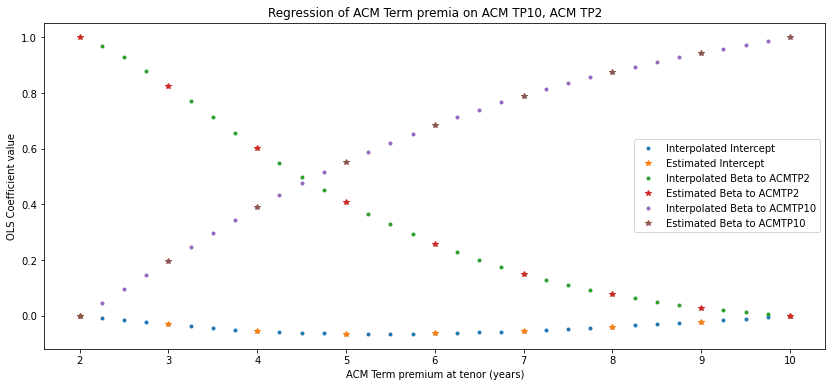

In [76]:
CoeffTP2_TP10 = MakeCoeffTP2_TP10(plot_coeff=True)
CoeffTP2_TP10.head().round(2)

#### B. Alternative: assume coefficient for interpolation and extrapolation of TP from TP2, TP10.

In [77]:
def AssumeCoeffTP2_TP10(plot_coeff=True):
    """
    AssumeCoeffTP2_TP10 can be used to assume some values of the coefficients mapping  term premia ACM10y and ACM2y to the term premia for tenors from 0y to 50y
    This is not used if the coefficients between 2y and 10y are estimated with the function MakeCoeffTP2_TP10, in which case the coefficients between 0y and 2y and between 10y and 50y are extrapolated with functions Extrap_TP0_TP2 and Extrap_TP10_TP50 
    
    """
    
    Tenor_y = np.array([2,3,5,7,10,20,30,50])
    Tenor_q = np.arange(2,50.25,0.25)
    Coeff_q = {}; Coeff_y = {}
    Coeff_y['Intercept'] = np.array([0,     0,     0,     0,    0,    0.5, 0.4064, 0.45])
    Coeff_y['ACMTP02']   = np.array([1, 0.847, 0.514, 0.255,    0,-0.0397,-0.6203, -.65])
    Coeff_y['ACMTP10']   = np.array([0, 0.185, 0.506, 0.746,    1, 1.0234, 1.2366, 1.3])
    for Regressor in ['Intercept', 'ACMTP02', 'ACMTP10']:
        #Coeff_y[Regressor] = np.append(Coeff_y[Regressor], np.poly1d(np.polyfit(Tenor_y[:-1], Coeff_y[Regressor] ,1))(50) )  # Extrapolate to add 50y point to Coeff_y
        Coeff_q[Regressor] = np.interp(Tenor_q, Tenor_y, Coeff_y[Regressor])  # Interpolate to get Coeff_q
    if plot_coeff == True:
        fig0 = plt.figure(figsize=[14,6]); plt.plot( 
            Tenor_q , Coeff_q['Intercept'], '.', 
            Tenor_y, Coeff_y['Intercept'], '*', 
            Tenor_q , Coeff_q['ACMTP02'], '.', 
            Tenor_y, Coeff_y['ACMTP02'], '*', 
            Tenor_q , Coeff_q['ACMTP10'], '.', 
            Tenor_y, Coeff_y['ACMTP10'], '*'
        )
        plt.legend(('Interpolated Intercept', 'Assumed Intercept', 'Interpolated Beta to ACMTP2', 'Assumed Beta to ACMTP2', 'Interpolated Beta to ACMTP10', 'Assumed Beta to ACMTP10'), loc='best')
        plt.xlabel('ACM Term premium at tenor (years)'); plt.ylabel('OLS Coefficient value'); plt.title('Projection of ACM Term premia on ACM TP10, ACM TP2');  #plt.show(block=False); 
    tpInterp = pd.DataFrame(Coeff_q, index=Tenor_q)
    tpInterp.index.names =['tenor']
    return tpInterp

Illustrate function use (actual use will be in F_SimRat):

,Intercept,ACMTP02,ACMTP10
tenor,,,
2.00,0.0,1.00,0.00
2.25,0.0,0.96,0.05
2.50,0.0,0.92,0.09
2.75,0.0,0.89,0.14
3.00,0.0,0.85,0.18


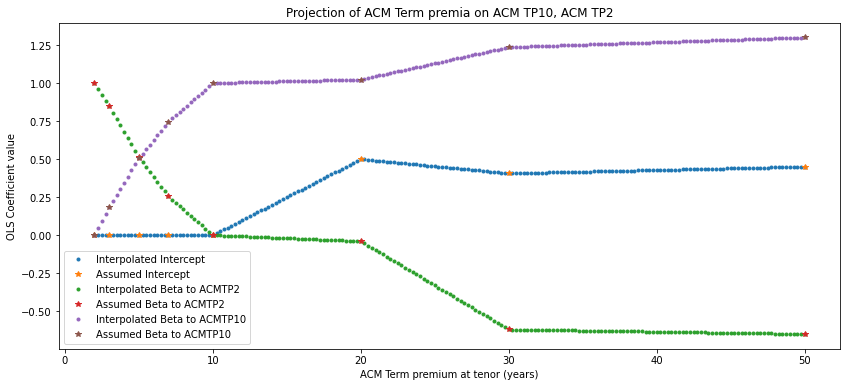

In [78]:
AssumeCoeffTP2_TP10(plot_coeff=True).head().round(2)


#### C. Extrpolate TP between 0y and 2y 

In [79]:
def Extrap_TP0_TP2_2(A_Storage,TP02series_q):
    """
    This function extrapolates the term premium for the first 8 quarters ahead tenors by tapering the 2y TP to zero.
    Term premia are added to the passed stored rates for the corresponding tenors. 
    """
    
    for qtr in [0,1,2,3,4,5,6,7]: #Add term premium for first eight quarters: from +0qtrs (now), to +7qtr (1yr 2qtrs).
        # TP linearly increases in qtrs +4,...,+7 from 0 towards TP2(value at +8 qtrs) 
        A_Storage[:,qtr,:] += xp.squeeze(TP02series_q) * qtr/8 

#### D. Interpolate TP between 2y and 10y (also extrapolates up to 50y if assumed coeffcients are passed)

In [80]:
def Interp_TP2_TP10_2(A_Storage, TP02series_q, TP10series_q, Coeff_q):
    """
    This function uses to the coefficients estimated with MakeCoeff_TP2_TP10 (or assumed with AssumeCoeff_TP2_TP10 ) to interpolate the term premia between 2y and 10y tenors (or up to 50y point with assumed coefficients)
    Term premia are added to the passed stored rates. 
    """
    
    cut = len(Coeff_q['Intercept'])+8 #Cutoff will be 41 (10y point) with estimation and 201 (50y) with assumption
    Intercept_q = xp.reshape(xp.asarray(Coeff_q['Intercept'], dtype=xp.float32), (1,-1,1))
    Beta_TP02_q = xp.reshape(xp.asarray(Coeff_q['ACMTP02'],   dtype=xp.float32), (-1,1))
    Beta_TP10_q = xp.reshape(xp.asarray(Coeff_q['ACMTP10'],   dtype=xp.float32), (-1,1))
    A_Storage[:,8:cut,:] += Intercept_q # Add is in place ...
    A_Storage[:,8:cut,:] += Beta_TP02_q @ TP02series_q   # ... but Matmul is not. suboptimal for memory management.. but improving seems hard. Can divide in blocks if too big. 
    A_Storage[:,8:cut,:] += Beta_TP10_q @ TP10series_q   # Extra: save separately TP05series_q as intermediate result for next function
    TP05series_q = Intercept_q[:,4*(5-2),:] + Beta_TP02_q[12] *  TP02series_q + Beta_TP10_q[12] *  TP10series_q
    return TP05series_q

#### E. Extrapolate TP from 10y to 50y (used by F_SimRate only when coefficients not assumed)

In [81]:
def Extrap_TP10_TP50_2(A_Storage, TP02series_q, TP05series_q, TP10series_q, 
                       plot_conv = False, use10y5yslope=True, use_convadj=False, replicateBeltonTP = True):
    """
    This function extrapolates the term premia for tenors between 10y and 50y by duration. Only used when TP out to 50y are not derived from assumed coefficients.
    0) Convexity adjustments a_{t} on ZCBs are interpolated at all ZCB tenors, using given values of convexity adjustmets for some given ZCB tenors 
    1) 10y and 2y (or 5y) Term Premia are converted in convexity adjusted. Suppose we are using 2y and rahter than 5y:
       TP2a = TP2 + a_{2};  TP10a = TP2 + a_{2}
    2) The slope between 2y and 10y convexity adjusted term premia is used to extrapolate convexity adjusted term premia by duration out to 50y . Duration is known (=maturity) because we are dealing with ZCB term premia
       TP50a = TP10a + (50-10) [TP10a-TP2a]/[10-2]
    4) The convexity adjustment is subtracted to get the term premia: 
       TP50 = TP50a - a_{50}
    5) Term premia are added to the passed stored rates for the relevant tenors.
    6) To replicate Belton et al, the extrapolated term premia need to be shifted by some ad hoc quantities. This is because we are using different convexity adjustments, in turn due to Belton et al intending the convexity adjustments as specified for par rates (rather than ZCBs) and using an approximation to get the duration of par notes before knowing their TPs.
    """
    
    Tenor_y =  np.array([    5,    10,    20,    30,    50])
    ConAdj_y = np.array([  2.7,   9.9,  33.4,  67.9, 188.6], dtype=np.float32)/100  #These are adjustments for ZCBs are different from Belton et al. where convexity adjustments were though of as for par rates, whose duration for extrapolation was approximated by the duration without term premium. 
    Tenor_q = np.reshape(np.arange(0,50.25,0.25, dtype=np.float32), (-1,1))
    A_Storage[:,41:,:] += (TP10series_q + ConAdj_y[Tenor_y==10][0]*use_convadj) #Intercept of extrapolation: add 10y premium with convexity adjustment...
    blocks = 8; size=int((201-41)/blocks)
    if use10y5yslope==True:
        Slope = ( TP10series_q + ConAdj_y[Tenor_y==10][0]*use_convadj  - (TP05series_q + ConAdj_y[Tenor_y==5][0]*use_convadj) )/(10-5)
    else: #Use instead the 2y-10y slope as initially mentioned in the paper.
        Slope = ( TP10series_q + ConAdj_y[Tenor_y==10][0]*use_convadj  - (TP02series_q + 0) )/(10-2)
    for block in range(blocks): #Do ten-year or 5-year horizon blocks to save on GPU memory space, at cost of minor speed deterioration. 
        start =  41+size*block; end = 41+size*(block+1)
        A_Storage[:,start:end,:] += (xp.asarray(Tenor_q[start:end])  - 10) @ Slope
    ConAdj_q = np.interp(Tenor_q, Tenor_y, ConAdj_y)
    if plot_conv == True:
        fig1 = plt.figure(figsize=[16/1.1, 9/1.1]); 
        plt.plot( Tenor_q , 100*ConAdj_q, '.', 
                  Tenor_y,  100*ConAdj_y, '*'); 
        plt.legend(('Interpolated Conv. Adjustment', 'Given Conv. Adjustment'), loc='best'); 
        plt.xlabel('Conv. Adjustment at tenor (years)'); 
        plt.ylabel('basis points'); 
        plt.title('Interpolation of Convexity Adjustments'); 
    if use_convadj==True:
        A_Storage[:,41:,:] -= xp.asarray(np.expand_dims(np.atleast_2d(ConAdj_q[41:]), 0))
    if replicateBeltonTP == True: #For exact replication, need to shift levels of TP, since we are not using the same convexity adjustments and same coefficients from ACM.
        Adj_Tenor_y = np.array([     1,    2,    3,    5,    7,   10,   20,   30,   50])
        Adj_y =       np.array([ -0.05,-0.02,-0.10,-0.08,-0.08,-0.08,-0.25,-0.45,-0.15])
        Adj_q =       xp.asarray(np.interp(Tenor_q, Adj_Tenor_y, Adj_y), dtype=xp.float32) 
        A_Storage +=  xp.reshape(Adj_q, (1,-1,1)) 

Illustrate Convexity Adjustments:

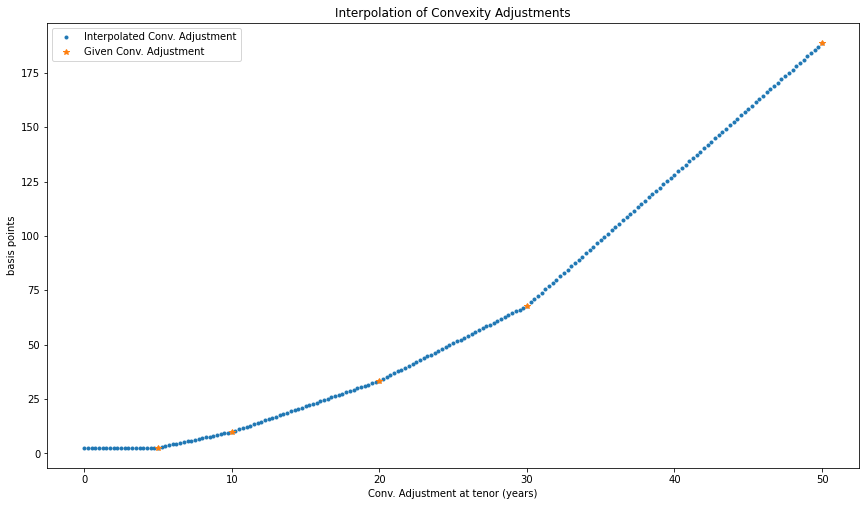

In [82]:
Tenor_y  = np.array([    5,    10,    20,    30,    50])
ConAdj_y = np.array([  2.7,   9.9,  33.4,  67.9, 188.6], dtype=np.float32)/100   
Tenor_q  = np.reshape(np.arange(0,50.25,0.25, dtype=np.float32), (-1,1))
ConAdj_q = np.interp(Tenor_q, Tenor_y, ConAdj_y)
fig1 = plt.figure(figsize=[16/1.1, 9/1.1]) 
plt.plot( Tenor_q , 100*ConAdj_q, '.', 
          Tenor_y,  100*ConAdj_y, '*'); 
plt.legend(('Interpolated Conv. Adjustment', 'Given Conv. Adjustment'), loc='best'); 
plt.xlabel('Conv. Adjustment at tenor (years)'); 
plt.ylabel('basis points'); 
plt.title('Interpolation of Convexity Adjustments'); 
del Tenor_y, ConAdj_y, Tenor_q, ConAdj_q, fig1

#### F. Convert Zero Curve to Par Curve

In [83]:
def MakeCoupRates(A_IRPaths):
    """
    Converts an array of Zero Yield Curves to an array of Par Yield Curves (in place, except for some extra temporary storage for discount factors)
    """
    exponents = xp.reshape(
        xp.arange(0,A_IRPaths.shape[1],dtype=xp.float32), 
        tuple([1,-1] + [1 for x in  range(A_IRPaths.ndim-2)])
    )
    DiscFactors = (1/(1+A_IRPaths/400))**exponents
    #DiscFactors = xp.exp((-A_IRPaths/400)*xp.reshape(xp.arange(0,A_IRPaths.shape[2],dtype=xp.float32), tuple([1,1,-1] + [1 for x in  range(A_IRPaths.ndim-3)]) ))
    for T in trange(1,A_IRPaths.shape[1]):
        A_IRPaths[:,T,...] = 400*(1-DiscFactors[:,T,...])/xp.sum(DiscFactors[:,1:T+1,...], axis=1)  

Also provide function for inverse trnsformation, used to check correctness and for plotting Zero Curve at a point in F_SimRate when only storage in memory is mean par rates.

In [84]:
def MakeZCBRates(A_NomsRates):
    """
    Converts an array of Par Yield Curves to an array of Zero Yield Curves (in place!)
    """
    
    A_NomsRates[:,1,...] = 1/(1+A_NomsRates[:,1,...]/400)  # Transform 1st par (=zcb) rate into 1st ZCB discount factor (do this for 0th par rate as well, inconsequential.)
    for T in range(2,A_NomsRates.shape[1]):                  # Get all other ZCB discount factors recursively "stripping the par curve":
        A_NomsRates[:,T,...] = (1 -  (A_NomsRates[:,T,...]/400)*xp.sum(A_NomsRates[:,1:T,...], axis=1)   ) /(1+ A_NomsRates[:,T,...]/400)
    A_NomsRates[:,1:,...] **= xp.reshape(-1/xp.arange(1,A_NomsRates.shape[1],dtype=xp.float32), tuple([1,-1] + [1 for x in  range(A_NomsRates.ndim-2)]) )   #Invert ZCB discount factors to get ZCB rates
    A_NomsRates[:,1:,...] -= 1 
    A_NomsRates[:,1:,...] *= 400   

#### G. Subtract on-the run adjustments to par curve 

In [85]:
def MakeOnTheRun(A_Storage): 
    """
    Subtracts on-the-run adjustments from par rates.
    """
        
    Tenor_y =     np.array([    0.25,    2,    3,    5,    7,   10,   20,   30,   50])
    OntheRun_y =  np.array([   -0.07,-0.02,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04])
    Tenor_q = np.reshape(np.arange(0,50.25,0.25, dtype=np.float32), (-1,1))
    OntheRun_q = xp.asarray(np.interp(Tenor_q, Tenor_y, OntheRun_y), dtype=xp.float32)
    A_Storage += xp.reshape(OntheRun_q, (1,-1,1))  

### 3. Term Premia: use functions A. - G. to create Nominal rates, adding term premia to avg. FFR

In [86]:
def MakeTPPaths2(
    A_SimObs, A_Storage, 
    plot_coeff = False, plot_conv = False, use10y5yslope=True, use_convadj=True, 
    estimate_not_assume=True, TP_is_for_ZeroCurve = True, replicateBeltonTP=True):
    """
    Combines the functions defined above to add TP for all tenors to the passed yields array. The passed array will be the expectational component. 
    """
    
    if estimate_not_assume == True: 
        # Time consuming unless ACM data already downloaded. Coeffs between 2y and 10y point.
        CoeffTP2_TP10 = MakeCoeffTP2_TP10(plot_coeff = plot_coeff) 
    else:
        # For checking results conditional on given coefficients, coeffs out to 50y point. 
        CoeffTP2_TP10 = AssumeCoeffTP2_TP10(plot_coeff = plot_coeff) 
    TP02series_q = xp.expand_dims(A_SimObs[:,5,:], 1)
    TP10series_q = xp.expand_dims(A_SimObs[:,4,:], 1)
    Extrap_TP0_TP2_2(A_Storage, TP02series_q)
    TP05series_q = Interp_TP2_TP10_2(A_Storage, TP02series_q, TP10series_q,  CoeffTP2_TP10)
    if estimate_not_assume == True: 
        Extrap_TP10_TP50_2(A_Storage, 
                           TP02series_q, 
                           TP05series_q, 
                           TP10series_q, 
                           plot_conv = plot_conv, 
                           use10y5yslope=use10y5yslope, 
                           use_convadj=use_convadj, 
                           replicateBeltonTP=replicateBeltonTP)
    if TP_is_for_ZeroCurve == True:
        # Note if estimate_not_assume = True, TP_is_for_ZeroCurve should also be set to True
        MakeCoupRates(A_Storage) 
    A_Storage[:,0:5,:] -= 0.08 # Adjust for Bill-FFR basis, 8bps in Belton et al.
    MakeOnTheRun(A_Storage)    # Adjust par rates for on-the run / off-the-run 

Compile Function (just for illustration with plotter below, will be called inside F_SimRat)

In [87]:
A_ExpFFR_05_10 = xp.copy(A_FFPaths[:,[4*5,4*10],:]) # Save a copy of 5y, 10y expected avg FFR before overwriting them when adding TP to them, will be needed for IRP. 
M_avgFFPaths = xp.mean(A_FFPaths, axis=2)           # Save a copy of mean expected avg FFR before overwriting it, will be needed for plotting with PlotRates. 
MakeTPPaths2(A_SimObs, A_FFPaths, 
    plot_coeff = False, plot_conv = False, use10y5yslope=True, use_convadj=True, 
    estimate_not_assume=True, TP_is_for_ZeroCurve = True, replicateBeltonTP=True)

### 3.bis: Plotter for mean nominal curve (Par and Zero)

In [88]:
def PlotRates(M_avgFFPaths, M_CRPaths): # Please provide already averaged across simualtions:  M_IRPaths = xp.mean(A_IRPaths, axis=2)
    M_IRPaths = xp.copy(M_CRPaths) # Create a copy (and not a view)...
    MakeZCBRates(M_IRPaths) # on which to apply in-place transformation to ZCB rates. 
    qtr_tenors = [4*yr_tenor for yr_tenor in[1,2,3,4,5,7,10,20,30,50]]
    if xp != np: 
        M_IRPaths, M_avgFFPaths, M_CRPaths= M_IRPaths.get(), M_avgFFPaths.get(), M_CRPaths.get()
    Arrays = [x[:,qtr_tenors] for x in [M_IRPaths, M_avgFFPaths, M_IRPaths-M_avgFFPaths, M_CRPaths, M_avgFFPaths,M_CRPaths-M_avgFFPaths ]]
    fig3, axes = plt.subplots(nrows= 4, ncols= 3 , sharex=True, sharey='none', figsize=(16,9)) 
    for r in [0,1]:
        for s in [0,1,2]:
            axes[r*2, s].set_prop_cycle(cycler(color=[plt.cm.get_cmap('rainbow')(x/len(qtr_tenors)) for x in range(1,len(qtr_tenors)+1)]))
            lines = axes[r*2, s].plot(Arrays[r*3+s]); 
            ylims = axes[r*2, s].set_ylim([(1,4),(1,4),(-1,2)][s])
            title = axes[r*2, s].set_title([['ZCB Rates','At Par Coupon Bonds rates'][r],'Avg. Exp. Future FFunds','Term Premium'][s])
        leg=axes[1,2].legend(iter(lines), [str(int(q/4))+' Yrs Maturity'for q in qtr_tenors  ], ncol=2, loc='upper right') 
        for s in [0,1]:
            title = axes[r*2+1, s].set_title(str(2+s*8) + 'y Rate Decomposition'); 
            lines = axes[r*2+1, s].plot( Arrays[0+r*3][:,1+s*5], 'black', Arrays[1+r*3][:,1+s*5], 'gold', Arrays[2+r*3][:,1+s*5], 'magenta' )
            ylims = axes[r*2+1, s].set_ylim((-1,4))
        leg=axes[3,2].legend(iter(lines),['Interest Rate','Avg. Fut. Exp. FFunds','Term Premium'], loc='upper right') ; axes[r*2+1,2].set_axis_off(); #plt.show(block=False)

Use plotter:

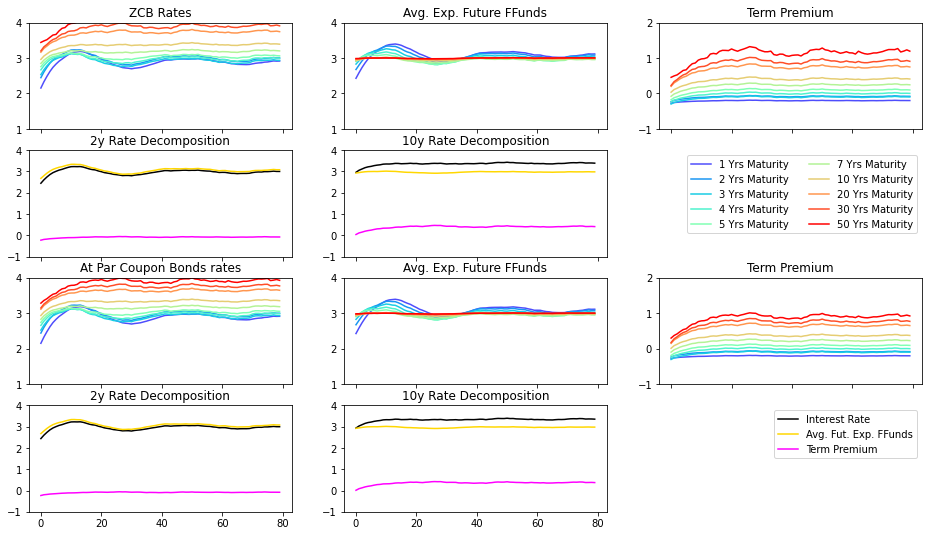

In [89]:
PlotRates(M_avgFFPaths, xp.mean(A_FFPaths, axis=2))

### 4. Compute Inflation Risk Premia

In [90]:
def F_MakeIRP(A_ExpFFR_05_10, A_SimSta, A_CPIPaths, plot_IRPcoeff=True, plot_IRP = True):  
    """
    This function computes the Inflation Risk Premia adding an AR1 residual to a linear function the 5y and 10y real rate gaps.
    In turn, the real rate gaps are defined as the difference of the real rate (=exp. FFR- exp. CPI ) minus R*.
    """
    
    Store_IRP=xp.zeros((A_SimSta.shape[0],1+4*30, A_SimSta.shape[2] ), dtype=xp.float32) 
    # Create AR1 residuals. Start by creating innovations
    if xp != np: IRP5_and_10 = xp.random.standard_normal(size=(A_SimSta.shape[0],2,A_SimSta.shape[2]),dtype = xp.float32) # Utterly important for GPU memory to use directly float32 rather than float64 and then convert. 
    else:        IRP5_and_10 = xp.random.standard_normal(size=(A_SimSta.shape[0],2,A_SimSta.shape[2])).astype(xp.float32) # Numpy does not support dtype argument in normal creation
    IRP5_and_10 *= 0.25 #Volatility of innovations to IRP5, IRP10 
    
    for t in range(1,A_SimSta.shape[0]): #Add up the innovations into the AR1 processes
        IRP5_and_10[t,:,:] += 0.7 * IRP5_and_10[t-1,:,:]  
    IRP5_and_10[:,0,:] += 0.61 - 0.145*((A_ExpFFR_05_10[:,0,:] - A_CPIPaths[:,5*4,:])  - (A_SimSta[:,1,:] + A_SimSta[:,2,:]))  # Add to AR1 to get IRP5
    IRP5_and_10[:,1,:] += 0.61 - 0.245*((A_ExpFFR_05_10[:,1,:] - A_CPIPaths[:,10*4,:]) - (A_SimSta[:,1,:] + A_SimSta[:,2,:]))  # Add to AR1 to get IRP10 
    Tenor_y = np.array([    2,    3,    5,    7,   10,   15,   20,   30])
    Consta  = np.array([    0,    0,    0,    0,    0,    0,    0,    0])
    Betas05 = np.array([ 1.02, 1.18,    1, 0.48,    0, 0.06, 0.10, 0.23])
    Betas10 = np.array([-0.49,-0.49,    0, 0.62,    1, 0.87, 0.88, 0.87])
    #Tenor_y = np.array([      2,      3,    5,      7,   10,     20,     30])  #These are alternative betas. 
    #Consta  = np.array([   0.08,   0.06,    0,  -0.02,    0, -0.025,  -0.05])
    #Betas05 = np.array([ 1.4833, 1.3781,    1, 0.538 ,    0,-0.3569,-0.3076])
    #Betas10 = np.array([-0.6137,-0.4722,    0, 0.5038,    1, 1.2343, 1.1907])
    Tenor_q = np.arange(0,30.25,0.25)
    Consta_q  = np.interp(Tenor_q, Tenor_y, Consta)
    Betas05_q = np.interp(Tenor_q, Tenor_y, Betas05) 
    Betas10_q = np.interp(Tenor_q, Tenor_y, Betas10) 

    if plot_IRPcoeff==True: 
        fig5 = plt.figure(figsize=[16/1.1, 9/1.1]); 
        plt.plot(Tenor_q , Consta_q, '.', 
                 Tenor_y, Consta, '*', 
                 Tenor_q , Betas05_q, '.', 
                 Tenor_y, Betas05, '*', 
                 Tenor_q , Betas10_q, '.', 
                 Tenor_y, Betas10, '*'
                ); 
        plt.legend(('Interpolated Constants',
                    'Given Constants',
                    'Interpolated Betas to IRP 5y',
                    'Given Betas to IRP 5y',
                    'Interpolated Betas to IRP 10y',
                    'Given Betas to IRP 10y')
                  ); 
        plt.title('Inflation Risk Premia Curve from 5y and 10y points')
    
    Store_IRP += xp.reshape(xp.asarray(Consta_q), (1,-1,1)) 
    Store_IRP += xp.atleast_2d(xp.asarray(Betas05_q)).T @ xp.expand_dims(IRP5_and_10[:,0,:],1)  
    Store_IRP += xp.atleast_2d(xp.asarray(Betas10_q)).T @ xp.expand_dims(IRP5_and_10[:,1,:],1)

    if plot_IRP == True: 
        fig6, axes = plt.subplots(nrows= 3, ncols= 2 , sharex=True, sharey='none', figsize=(16,16)); 
        if xp != np: 
            Arrays = [xp.mean(Store_IRP[:,[x*4 for x in [2,3,5,7,10,15,20,30]],:],2).get(), xp.mean(A_ExpFFR_05_10,2).get(), xp.mean(A_SimSta[:,1,:] + A_SimSta[:,2,:],1).get(), xp.mean(A_CPIPaths[:,[4*5,4*10],:],2).get()]
        else:        
            Arrays = [xp.mean(Store_IRP[:,[x*4 for x in [2,3,5,7,10,15,20,30]],:],2)      , xp.mean(A_ExpFFR_05_10,2)      , xp.mean(A_SimSta[:,1,:] + A_SimSta[:,2,:],1)      , xp.mean(A_CPIPaths[:,[4*5,4*10],:],2)      ]
        colors = [plt.cm.get_cmap('rainbow')(x/len(Tenor_y)) for x in range(1,len(Tenor_y)+1)]
        axes[0, 0].set_prop_cycle(cycler(color=colors))
        Legendpieces = [ str(Tenor_y[x])+'y = '+ str(round(Betas05[x],2))+ ' x 5y ' + ('+'+str(round(Betas10[x],2)))[-5:] + ' x 10y + eps_'+str(Tenor_y[x]) for x in range(len(Tenor_y))]; 
        Legendpieces[2]='5y = 0.61 - 0.145 Rgap5'; 
        Legendpieces[4]='10y = 0.61 - 0.245 Rgap10'
        lines = axes[0,0].plot(Arrays[0]); 
        axes[0,0].set_title('Inflation Risk Premia (mean)'); 
        axes[0,0].legend(iter(lines), Legendpieces, loc=0) 
        lines = axes[0,1].plot((Arrays[1]-Arrays[3])-np.expand_dims(Arrays[2],1)); 
        axes[0,1].set_title('R gap = R - Rstar'); 
        axes[0,1].legend(iter(lines), ('5y Rgap, mean', '10y Rgap, mean'), loc='upper right') 
        lines = axes[1,0].plot(Arrays[1]-Arrays[3]); 
        axes[1,0].set_title('R = Exp Nom - Exp Inf'); 
        axes[1,0].legend(iter(lines), ('5y R, mean', '10y R, mean'), loc='upper right') 
        lines = axes[1,1].plot(Arrays[2], 'k'); 
        axes[1,1].set_title('R star (mean)'); 
        axes[1,1].legend(('Rstar = Z state + G state'), loc='best')
        lines = axes[2,0].plot(Arrays[3]); 
        axes[2,0].set_title('Expected inflation rate (avg future CPI, mean)'); 
        axes[2,0].legend(iter(lines), ('5y horizon', '10y horizon'), loc='upper right') 
        lines = axes[2,1].plot(Arrays[1]); 
        axes[2,1].set_title('Expected nominal rate (avg future FFR, mean)'); 
        axes[2,1].legend(iter(lines), ('5y horizon', '10y horizon'), loc='upper right') 
    
    return Store_IRP

Illustrate IRP, Real Rates, and Expected Inflation

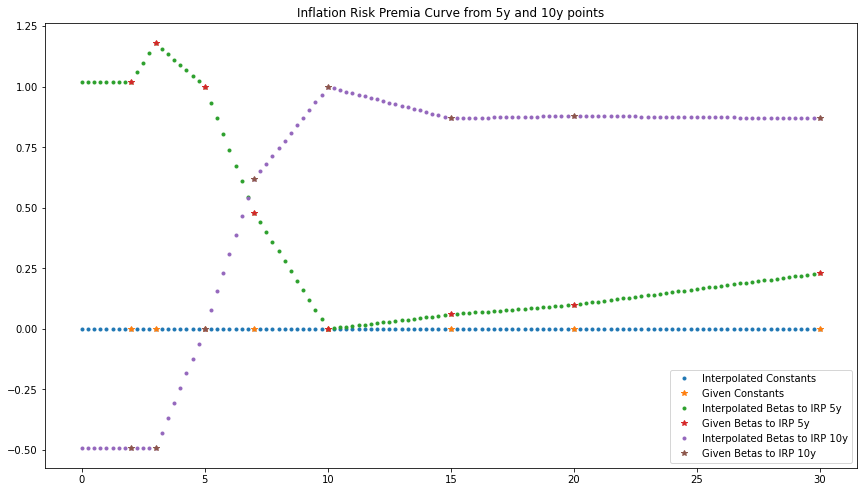

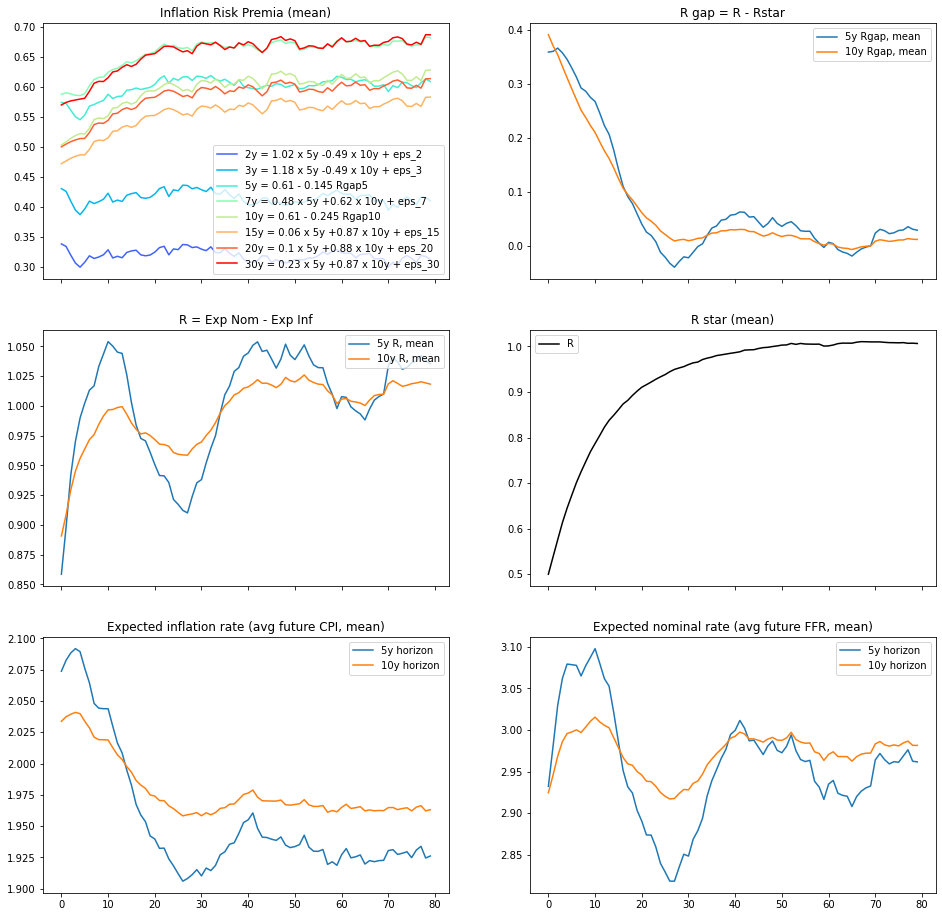

In [91]:
Store_IRP = F_MakeIRP(A_ExpFFR_05_10, A_SimSta, A_CPIPaths, plot_IRPcoeff=True, plot_IRP = True)

In [92]:
# Delete all storages we used for illustration of intermediate results.
del A_ExpFFR_05_10, Store_IRP, M_avgFFPaths, A_FFPaths, A_CPIPaths 

### 5. Add Liquidity Risk Premia

In [93]:
def F_addLRP(Storage):
    """
    This function adds the constant liquidity risk premia to the passed array.
    The premia are fixed to 45,32,24,19 bps for the 2y,5y,10y,30y points, and interpolated/extrapolated elsewhere.
    """
        
    n_exp_hor = Storage.shape[1]
    Tenor_y = np.array([2,5,10,30])
    LRP_y = np.array([45,32,24,19])/100
    Tenor_q = np.arange(0,n_exp_hor*0.25,0.25)
    LRP_q = np.interp(Tenor_q, Tenor_y, LRP_y) 
    Storage += xp.reshape(xp.asarray(LRP_q), (1,-1,1)) 

## Rates Block: overall wrapper

In [94]:
# Wrapper for memory management, does entire rates block and overwrites intermediate results (Fed Fund rates, TPremia, ZCB rates) and only returns rates on Coupon Bonds isued at par. Averages of intermediate results can be shown setting plot_rates=True
def F_SimRat(A_SimSta, A_SimObs, ModelMats, 
             n_exp_horizon=201, 
             plot_rates=True, plot_coeff = True, plot_conv = True, 
             use10y5yslope=True, use_convadj=True, 
             plot_IRPcoeff=True, plot_IRP = True, 
             estimate_not_assume=True, TP_is_for_ZeroCurve = True, replicateBeltonTP=True): 
    """
    This wraps together all functions of the rates block. The output are arrays with Nominal Rates, FRN Rates, TIPS Rates
    1) creates the expectational component in A_Storage with MakeFFPaths3. Expected CPI rates are also stored in A_CPIPaths
    2) Creates the FRN rates adding the FRP to the expectational component
    3) Creates the Nominal Rates by adding TP to the expectational component (mapping of the zero curve to par curve is done inside MakeTPPaths2) 
    4) A_Storage is now the par curve of Nominal Rates (exp. comp +TP)
    5) Creates the Inflation Risk Premia, IRP, with F_MakeIRP, in the array A_StoreIRP
    6) Switches sign and adds nominal rates to have  A_StoreIRP = (ExpNom + TP) - IRP
    7) To get TIPS rates, subtracts expected CPI inflation and adds the liquidity risk premia LRP, so that A_StoreIRP = ExpNom - ExpInf + TP - IRP + LRP  = (ExpNom-ExpINF) + (TP - IRP - FRP ) + FRP + LRP =  R + RRP + FRP + LRP = TIPS 
    """
    
    A_Storage = xp.empty((A_SimSta.shape[0], n_exp_horizon, A_SimSta.shape[2] ), dtype=xp.float32) 
    A_CPIPaths = xp.empty((A_SimSta.shape[0], 30*4+1, A_SimSta.shape[2] ), dtype=xp.float32) 
    print('MakeFFPaths3')
    MakeFFPaths3(A_SimSta, ModelMats, A_Storage, A_CPIPaths)
    M_avgFFPaths = xp.mean(A_Storage, axis=2)  # Small extra storage for plotting with plot_rates
    A_ExpFFR_05_10 = xp.copy(A_Storage[:,[4*5,4*10],:]) # Again, extra storage for expected FFR before overwriting them when adding TP to them.         
    A_FRNRates = xp.zeros((A_SimSta.shape[0], 1+5*4, A_SimSta.shape[2] ), dtype=xp.float32)  #Create storage for FRN rates
    A_FRNRates += xp.expand_dims(A_Storage[:,1,:],1); 
    F_addFRP(A_FRNRates) #Set FRN rate equal to 3 month expected FFR plus FRP premium.
    print('MakeTPPaths2')
    MakeTPPaths2(A_SimObs, A_Storage, plot_coeff = plot_coeff, 
                 plot_conv = plot_conv, use10y5yslope=use10y5yslope, 
                 use_convadj=use_convadj, estimate_not_assume=estimate_not_assume, 
                 TP_is_for_ZeroCurve = TP_is_for_ZeroCurve, replicateBeltonTP=replicateBeltonTP
                ) #Notice it also transforms to par coupon rates
    if plot_rates==True :
        PlotRates(M_avgFFPaths, xp.mean(A_Storage, axis=2))
    #Get inflation risk premium for horizons up to 30y: Store = IRP
    print('Make IRP')
    A_StoreIRP = F_MakeIRP(A_ExpFFR_05_10, A_SimSta, A_CPIPaths, plot_IRPcoeff=plot_IRPcoeff, plot_IRP = plot_IRP) 
    A_StoreIRP *= -1                      # Flip sign:           Store  =    - IRP
    A_StoreIRP += A_Storage[:,:30*4+1,:]  # Add nominal yields:  Store =  (ExpNom + TP) - IRP
    A_StoreIRP -= A_CPIPaths[:,:30*4+1,:]; 
    F_addLRP(A_StoreIRP); # Subtract expected inflation and add LRP to get tips yield: Store = ExpNom - ExpInf + TP - IRP + LRP  = (ExpNom-ExpINF) + (TP - IRP - FRP ) + FRP + LRP =  R + RRP + FRP + LRP = TIPS 
    return A_Storage, A_StoreIRP, A_FRNRates 

Use function:

In [95]:
A_NomsRates, A_TipsRates, A_FrnsRates = F_SimRat(
    A_SimSta, 
    A_SimObs, 
    ModelMats, 
    plot_rates=False, 
    plot_coeff = False, 
    plot_conv = False, 
    use10y5yslope= D_Setup["use10y5yslope"], 
    use_convadj=D_Setup["use_convadj"], 
    plot_IRPcoeff=False, 
    plot_IRP = False, 
    estimate_not_assume=D_Setup["estimate_not_assume"], 
    TP_is_for_ZeroCurve = True, 
    replicateBeltonTP=D_Setup["replicateBeltonTP"])

MakeFFPaths3



MakeTPPaths2



Make IRP


## V) Debt Block
The code is organized as follows:
1. F_InitiProfiles gets at the given start date the profile of outstanding face value and coupon rates for TIPS and Nominal securities at all tenors
2. MakeGDPPaths creates the path of GDP fron Init_GDP and the simulated paths of G, UGAP, PI.
3. F_MakeDebtStorages creates storage arrays needed in the main debt block loop.
4. F_MakeRateStorages creates views of the rates arrays and related indexes needed in the main debt loop.
5. MakeDbtPaths1 is the main debt block loop. 


### 1. Get Initial Debt Profiles (Face Values and Coupon Rates)

In [96]:
# Calibrate initial Debt and Average Coupon Rates Profile across tenors. 
# Notice that there are no FRNs in the dataset... Their initial Face Values are set to zero.
def F_InitiProfiles(
    startyear,
    startquarter,
    No_TIPS_FRN,
    n_exp_horizon, path_CRSP = None, 
    plotFigs=True):
    """
    Given an arbitrary date, this function gets the profile of outstanding face value and coupon rates for TIPS and Nominal securities at all tenors
    """
    
    try:    # If CRSP dadaset has already been prepared, just read results
        FVALUESq = pd.read_csv('../data/FVALUESq.csv', index_col=0, parse_dates=True)
        COURATEq = pd.read_csv('../data/COURATEq.csv', index_col=0, parse_dates=True)
    except: # Otherwise do the work to prepare the data and then save a copy for next use. 
        CRSP = pd.read_excel(path_CRSP, parse_dates=True) # Read CRSP data
        # Replace 'Non Answerable' instances of total Face Value inferring it from closest history of same security
        for nanobs in CRSP.index[CRSP['TMTOTOUT'].isna()]:
            temp = CRSP.loc[CRSP['KYTREASNO'] == CRSP.loc[nanobs,'KYTREASNO'], ['TMTOTOUT', 'MCALDT']] # Get history of security with a missing Face value entry
            if temp.index.size > 1:
                CRSP.loc[nanobs,'TMTOTOUT' ] = CRSP.loc[(temp.loc[temp.index != nanobs, 'MCALDT'] - temp.loc[nanobs,'MCALDT'] ).abs().idxmin(),'TMTOTOUT']    
        CRSP=CRSP[CRSP['TMTOTOUT'].isna()==False] #Drop the remaining nan observations (less than 50 obs out of around 150 000)
        CRSP['TMPRIOUT'] =  CRSP['TMTOTOUT'] - CRSP['TMPUBOUT'] # Privately held values are Total - Publicly Held.

        # Code to first build monthly horizons, in order to also have debt repaid in just finished quarter (HORIZON 0)
        CRSP['curMnt'] = CRSP['MCALDT'].dt.year*12+CRSP['MCALDT'].dt.month
        CRSP['endMnt'] = CRSP['TMATDT'].dt.year*12+CRSP['TMATDT'].dt.month
        CRSP['MNTSTOMAT'] = CRSP['endMnt']-CRSP['curMnt'] 

        # Compute outstanding face value profile, also distinguishing private and total outstanding
        CRSP['TMTOTOUT_ofTIPS'] = CRSP['TMTOTOUT'] * CRSP['ITYPE'].isin([11,12])
        CRSP['TMTOTOUT_noTIPS'] = CRSP['TMTOTOUT'] * (1-CRSP['ITYPE'].isin([11,12]))

        FVALUESm = CRSP[['MCALDT','MNTSTOMAT', 'TMTOTOUT_noTIPS', 'TMTOTOUT_ofTIPS']].fillna(np.inf).groupby(by=['MCALDT', 'MNTSTOMAT']).sum().replace(np.inf, np.nan)
        FVALUESm = FVALUESm.unstack('MNTSTOMAT', fill_value = 0).resample('M').ffill()                                                                # Horizon to maturity used to create columns. 
        FVALUESm[[('TMTOTOUT_noTIPS',0), ('TMTOTOUT_ofTIPS',0)]] = FVALUESm[[('TMTOTOUT_noTIPS',1), ('TMTOTOUT_ofTIPS',1)]].shift(1)                  # Assume FV repaid in month just ended was the outstanding for that month measured at the end of previous month.
        FVALUESq= FVALUESm.fillna(np.inf).groupby(lambda x: 'FV' + x[0][9:15] + str(np.int(np.ceil(x[1]/3))) , axis=1).sum().replace(np.inf, np.nan)  # Aggregate horizons to quarters. Note how 0th columns are unchanged.
        FVALUESq[['FVofTIPS0', 'FVnoTIPS0']] = FVALUESq[['FVofTIPS0', 'FVnoTIPS0']].rolling(3).sum(skipna=False);                                     # Aggregate FV repaid in last 3 months to get FV repaid in last quarter. 
        FVALUESq = FVALUESq.resample('Q').ffill() 
        FVALUESq.to_csv('../data/FVALUESq.csv', index = True)

        # Compute weighted average coupon rate profile
        COURATEm = CRSP[['MCALDT','MNTSTOMAT','TMTOTOUT_noTIPS','TMTOTOUT_ofTIPS','TCOUPRT']] #'TMYLD' has strictly worse coverage than 'TMPCYLD', and substantially same info on YTM.
        COURATEm = COURATEm.assign(ANNCOUSIZE_noTIPS = COURATEm['TCOUPRT']*0.01*COURATEm['TMTOTOUT_noTIPS'], ANNCOUSIZE_ofTIPS = COURATEm['TCOUPRT']*0.01*COURATEm['TMTOTOUT_ofTIPS'], QTRSTOMAT = np.ceil(COURATEm['MNTSTOMAT']/3)).drop(columns=['TCOUPRT', 'MNTSTOMAT'] )
        COURATEm = COURATEm.fillna(np.inf).groupby(by=['MCALDT', 'QTRSTOMAT']).sum().replace(np.inf, np.nan) 
        COURATEm = COURATEm.assign(AVGCOURT_noTIPS = 100*COURATEm['ANNCOUSIZE_noTIPS']/COURATEm['TMTOTOUT_noTIPS'], AVGCOURT_ofTIPS = 100*COURATEm['ANNCOUSIZE_ofTIPS']/COURATEm['TMTOTOUT_ofTIPS']).drop(columns=['TMTOTOUT_noTIPS','ANNCOUSIZE_noTIPS','TMTOTOUT_ofTIPS','ANNCOUSIZE_ofTIPS'])
        COURATEq = COURATEm.unstack('QTRSTOMAT', fill_value = np.nan).resample('Q').ffill()                 # Horizon to maturity used to create columns. 
        COURATEq = COURATEq.fillna(np.inf).groupby(lambda x: x[0] + str(np.int(x[1])) , axis=1).sum().replace(np.inf, np.nan) #Consolidate 2 levels of labels to column titles
        COURATEq['AVGCOURT_noTIPS0'] = np.NaN; COURATEq['AVGCOURT_ofTIPS0'] = np.NaN
        COURATEq.to_csv('../data/COURATEq.csv', index = True)
    # Use Data to set initial debt and coupon profiles. 
    startdate= str(int(startyear)) +'-'+ ('0' + str(int(startquarter*3)))[-2:] +'-'+ str(30+1*(startquarter==1 or startquarter==4))
    MaxAhead = int(FVALUESq.shape[1]/2); 
    Init_DbtFVout=np.zeros((n_exp_horizon,2));  
    Init_DbtFVout[0:min(MaxAhead,n_exp_horizon),0] = FVALUESq.loc[startdate, ['FVnoTIPS' + str(x) for x in np.arange(MaxAhead)]]
    Init_DbtFVout[0:min(MaxAhead,n_exp_horizon),1] = FVALUESq.loc[startdate, ['FVofTIPS' + str(x) for x in np.arange(MaxAhead)]]
    Init_DbtFVout /= 1000 ;  #Divide by 1000 to change units from millions to billions.  
    MaxAheadc = int(COURATEq.shape[1]/2)
    Init_AvgCoupRate=np.empty((n_exp_horizon,2)); Init_AvgCoupRate[:]= np.nan; 
    Init_AvgCoupRate[0:min(MaxAheadc,n_exp_horizon),0] = COURATEq.loc[startdate, ['AVGCOURT_noTIPS' + str(x) for x in np.arange(MaxAheadc)]]
    Init_AvgCoupRate[0:min(MaxAheadc,n_exp_horizon),1] = COURATEq.loc[startdate, ['AVGCOURT_ofTIPS' + str(x) for x in np.arange(MaxAheadc)]]
    # Plot the initial profiles
    if plotFigs==True:
        Init_AvgCoupRate_toplot = np.copy(Init_AvgCoupRate); 
        Init_AvgCoupRate_toplot[np.isnan(Init_AvgCoupRate_toplot)]=-99
        Ticks= [str(round(x/4)) + 'y' for x in np.arange(0,n_exp_horizon,20)] 
        fig, ax = plt.subplots(2,2, sharex=True, figsize=(14,12))
        for col in range(2):
            ax[0,col].plot(Init_DbtFVout[:,col], c='red'); 
            ax[0,col].set_ylabel('Bn USD'); 
            ax[0,col].set_yscale('linear'); 
            ax[0,col].legend(['Face Value Outstanding by tenor']); 
            ax[0,col].set_title('Initial '+ ['Nominal', 'TIPS'][col] +' Debt Profile at start date ' + startdate)
            ax[1,col].plot(Init_AvgCoupRate_toplot[:,col], c='black'); 
            ax1r = ax[1,col].twinx(); 
            ax1r.plot(Init_DbtFVout[:,col], '--',c='red',linewidth=0.75); 
            ax1r.set_ylabel('Bn USD'); 
            ax1r.set_yscale('log'); 
            ax1r.legend(['Log Face Value Outstanding'], loc='lower right'); 
            ax[1,col].set_xticks([x for x in np.arange(0,n_exp_horizon,20)]); 
            ax[1,col].set_xticklabels(Ticks); ax[1,col].set_ylabel('%'); 
            ax[1,col].legend(['Average Coupon Rate on ' + ['Nominal', 'TIPS'][col] + ' Debt by tenor']); 
            ax[1,col].set_title('Initial Average ' + ['Coupon', 'TIPS'][col] + ' Rate Profile at start date ' + startdate)
            ax[1,col].set_xlim((0,4*40)); 
            ax[1,col].set_ylim(0, max(Init_AvgCoupRate_toplot[:,col])+1); 
            ax[0,col].set_ylim(0); 
            ax1r.set_ylim(1,max(Init_DbtFVout[:,col])*50 ); 
            ax[1,col].set_xlabel('Tenor: years ahead')
    Init_TipsFVadj = Init_DbtFVout[:,1]; Init_FrnsFV =   xp.zeros(n_exp_horizon) # Temporary, till we retrieve data on CPI index ratios and FRNs securities from MSPD
    if No_TIPS_FRN== True:
        Init_DbtFVout[:,1]*=0; Init_AvgCoupRate[:,1]*=0; Init_TipsFVadj*=0; Init_FrnsFV*=0 #Drop TIPS and FRNs initial securities.
    return (
        xp.asarray(Init_DbtFVout, dtype=xp.float32),    # Face Values of Nominals and TIPS
        xp.asarray(Init_AvgCoupRate, dtype=xp.float32), # Average Coupon Rates of Nominals and TIPS
        xp.asarray(Init_TipsFVadj, dtype=xp.float32),   # Adjusted Face Values of TIPS
        xp.asarray(Init_FrnsFV, dtype=xp.float32)       # Face Values of FRNs
    )

Use function:

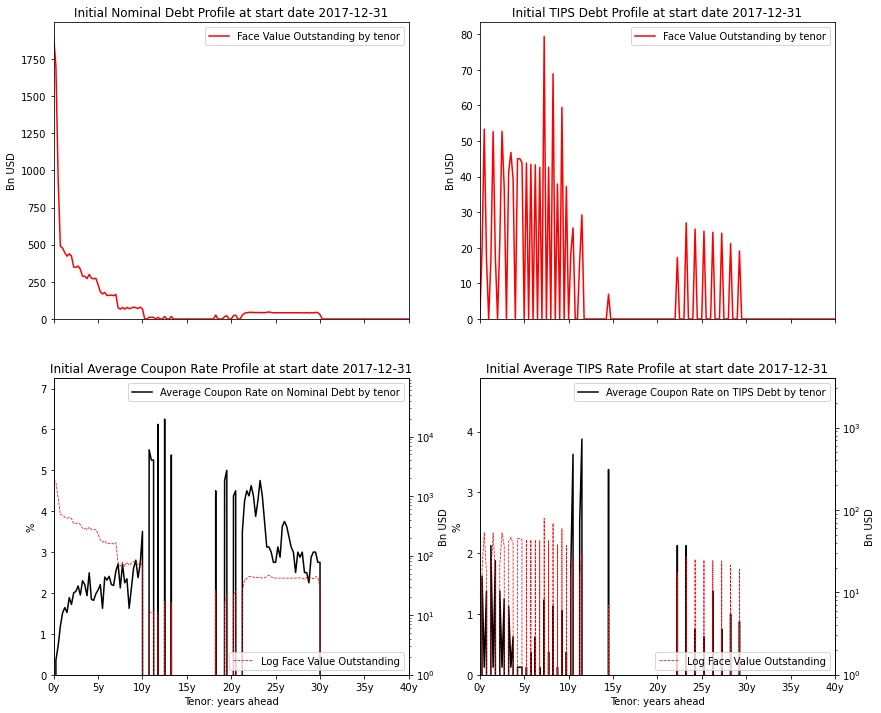

In [97]:
Init_DebtProfiles = F_InitiProfiles(D_Setup["start_year"],D_Setup["start_quarter"], D_Setup["No_TIPS_FRN"], D_Setup["n_exp_horizon"],
                                    path_CRSP=None, plotFigs=True)
#Init_DbtFVout, Init_AvgCoupRate, Init_TipsFVadj, Init_FrnsFV = Init_DebtProfiles

### 2. Create paths of GDP

In [98]:
def MakeGDPPaths(Init_GDP, A_SimSta): # Notice that fixing initial price level as base, Init_GDP = Init_RGDP.   
    """
    This function creates paths for GDP from an initial level.
    1) uses the Belton et al 'Okun Law' to map initial real GDP to initial potential GDP through the UGAP.
    2) potential real gdp grows following the G state
    3) Okun law is used again to get RGDP from potential gdp. 
    4) PCE is used to map RGDP to NGDP.
    """
    Init_RGDP = Init_GDP  #Just use our initial date as deflator start.
    Init_Pot_RGDP = Init_RGDP / (1 + 2*A_SimSta[0,0,0]/400) # POTRGDP = RGDP / (1 + RGDPGAP%), where RGDPGAP=2 x Unemployment Gap by Okun Law. Take 0th simulation UGAP wlog since in period zero all simulations start at assumed initial state. 
    A_Pot_RGDP = Init_Pot_RGDP * xp.cumprod(1+(A_SimSta[:,1,:])/400, axis=0)  # Potential RGDP quarterly growth is G state. 
    A_RGDP = A_Pot_RGDP * (1 + 2*A_SimSta[:,0,:]/400)                         # Apply Okun Law again to get RGDP paths
    A_NGDP = A_RGDP * xp.cumprod(1+(A_SimSta[:,3,:])/400, axis=0)             # Multiply by cumulative inflation to get nominal GDP
    return A_NGDP 

Use function:

In [99]:
A_NGDP = MakeGDPPaths(Init_GDP, A_SimSta)

### 3. Create debt storage arrays

In [100]:
def F_MakeDebtStorages(n_period,n_exp_horizon,n_simula): # Prepares the storage spaces for Debt Block
    """
    Prepares storage arrays that will be used in the main debt block function
    """
    
    A_NomsFV     = xp.zeros((n_exp_horizon,n_simula), dtype=xp.float32)         # Tracks profiles of FVs for Nominals.  Shape n_exp_horizon x n_simula                                              
    A_TipsFV     = xp.copy(A_NomsFV)                                            # Tracks profiles of FVs for TIPS.      Shape n_exp_horizon x n_simula
    A_TipsFVadj  = xp.copy(A_NomsFV)                                            # Tracks profiles of inflation-adjusted FVs for TIPS. Shape n_exp_horizon x n_simula
    A_TipsFVmax  = xp.copy(A_NomsFV)                                            
    A_TipsFVmaxOLD = xp.copy(A_NomsFV) 
    A_FrnsFV     = xp.copy(A_NomsFV)                                            # Tracks profiles of FVs for FRNS.      Shape n_exp_horizon x n_simula                                         
    A_IRCost     = xp.zeros((n_period,n_simula), dtype=xp.float32)              # Tracks interest cost from coupons generating cash flows. Shape n_period x n_simula
    A_TipsFVCost = xp.copy(A_IRCost)                                            # Tracks interest cost that TIPS accrue (without cash flow) at time t as inflation/deflation of their principal. Shape n_period x n_simula
    A_DbtSvc     = xp.copy(A_IRCost)                                            # Tracks debt service cost, sum of coupon cost and maturing face values (for tips, maturing is max(FV, adjFV)).  Shape n_period x n_simula
    A_TotDfc     = xp.copy(A_IRCost)                                            # Tracks financing need, sum of debt service cost (above) plus primary deficit. Shape n_period x n_simula
    Avg_IssRate  = xp.zeros(n_period, dtype=xp.float32)                         # Tracks average issuance coupon rate. Shape n_period
    A_TotCoup    = xp.zeros((n_exp_horizon,2,n_simula), dtype=xp.float32)       # Tracks total coupons at every tenor from Nominals and Inflation-adjsuted coupons from tips.  Shape n_exp_horizon x 2 x n_simula
    Store_Pvals  = xp.zeros((n_exp_horizon-1,n_simula), dtype=xp.float32)       # Computes sum of TIPS and Noms par FVs (=PVs) to get TOTdebt and WAM
    TotDebt      = xp.copy(A_IRCost)
    WAM          = xp.copy(A_IRCost)
    del n_period,n_exp_horizon,n_simula
    return locals().copy()

Use function:

In [101]:
DebtStorages = F_MakeDebtStorages(D_Setup["n_period"],D_Setup["n_exp_horizon"],D_Setup["n_simula"])

### 4. Create rate views and index arrays

In [102]:
def F_MakeRateStorages(Securities, A_NomsRates, A_TipsRates, A_FrnsRates):
    NomsWhere,  TipsWhere,  FrnsWhere =  [  Securities[0,:]==x  for x in [0,1,2]][:]
    NomsTenors, TipsTenors, FrnsTenors = [4*Securities[1,x].astype(np.int32) for x in [NomsWhere,TipsWhere,FrnsWhere]][:]
    NomsPos,       TipsPos,    FrnsPos = [np.arange(len(x))[x] for x in [NomsWhere,  TipsWhere,  FrnsWhere]][:]
    MaxFrnsTen = np.max(np.append(FrnsTenors,-1))
    A_NomsRates_view, A_TipsRates_view, A_FrnsRates_view = A_NomsRates[:,NomsTenors,:], A_TipsRates[:,TipsTenors,:], A_FrnsRates[:,:MaxFrnsTen+1,:] #Prepare views in advance.
    return NomsPos,  TipsPos,  FrnsPos, NomsTenors, TipsTenors, FrnsTenors, MaxFrnsTen, A_NomsRates_view, A_TipsRates_view, A_FrnsRates_view

Use function:

In [103]:
RateStorages = F_MakeRateStorages(D_Setup["Securities"], A_NomsRates, A_TipsRates, A_FrnsRates)# Pre-slices Rates arrays, creates some indexes. 

### 5. Main Debt Block Loop

In [104]:
def MakeDbtPaths1(
    Init_DbtFVout, 
    Init_AvgCoupRate, 
    Init_TipsFVadj, 
    Init_FrnsFV, 
    IssuanceStrat, 
    NomsPos,  
    TipsPos,  
    FrnsPos, 
    NomsTenors, 
    TipsTenors, 
    FrnsTenors, 
    MaxFrnsTen, 
    A_NomsRates_view, 
    A_TipsRates_view, 
    A_FrnsRates_view, 
    A_SimObs, 
    A_NGDP, 
    A_NomsFV, 
    A_TipsFV, 
    A_TipsFVadj, 
    A_TipsFVmax, 
    A_TipsFVmaxOLD, 
    A_FrnsFV, 
    A_IRCost, 
    A_TipsFVCost, 
    A_DbtSvc,
    A_TotDfc, 
    Avg_IssRate, 
    A_TotCoup, 
    Store_Pvals, 
    TotDebt, 
    WAM, 
    M_Kernels=None, 
    CoeffstoConst_and_MEVs = None,
    UnadjustedKernelIssuance=None, 
    SumUnadjustedKernelIssuance=None,
    TrackWAM=False, 
    Dynamic = False, 
    QuartersperCoup=1,
    n_exp_horizon=201,
    verbose=True): 
    """
    Debt block function.
    1) Initializes the Face Values and Coupons using the initial profiles, pre computes quarterly primary deficit and quarterly CPI gross inflation
    2) For every quarter t>0
       A) Rolls the storage arrays for face values and coupons by shifting them back 1 position in the the tenor horizons axis, and add a zero for the last horizon.
       B) Updates the inflation adjusted coupons on TIPS by current gross CPI inflation
       C) computes the old an new maximum for tips between face value and inflation adjusted face value
       D) Computes the accrual of TIPS face value adjustment by computing the change in this maximum
       E) computes the cash-flow interest cost suming up coupons generated by nomnal securities and tips securities at all outstanding tenors, adding the interest on FRNs which is equal to their face value times current 3month rate on nominals. 
       E.bis) if QuartersperCoup=2, coupons are semiannual: only even quarters ahead generate interest cost (scaled by 2 since coupon rates are kept to be qurterly)
       F) Debt service is interest cost + face value maturing. 
       G) Total deficit, or total financing need, is debt service plus primary deficit.
       H) If Dynamic is False, the financing need is split across tenors and securities acording to the issuance shares specified in the passed strategy
       I) If Dynamic is true, the  financing neeed is split across tenors and securities using the pre-computed Kernels x Coefficients x MEVs, plus the part of Kernels x Coefficient x Interest Cost, all adjusted by the h_Index
        the resulting issuance shares are stored for reference. 
       L) New issuance is added to face values (at the issued tenors) for all types of securities. 
       M) New Issuance times current nominal rates is used to add to the array storing coupon cost generated by outstanding nominal securities. Same for TIPS.
       N) Average issuance rate is computed and stored
       O)Total debt is computed and stored
       P) h_index is updated, if Dynamic=True
       Q) if TrackWAM=True, Weighted Average Maturity of debt is computed and stored. 
    After all t are computed, the accrued costs of TIPS face value adjustments are added to the interest costs that generated cash flows. 
    """
    
    n_period = A_NomsRates_view.shape[0]                                               # For clarity
    A_NomsFV[:,:]    = xp.reshape(Init_DbtFVout[:,0],(-1,1))                      # Initial profile of Nominal debt outstanding face values
    A_TipsFV[:,:]    = xp.reshape(Init_DbtFVout[:,1],(-1,1))                      # Initial profile of TIPS debt outstanding face values, NOT INFLATION ADJUSTED
    A_TipsFVadj[:,:] = xp.reshape(Init_TipsFVadj    ,(-1,1))                      # Initial profile of TIPS debt outstanding face values, CPI INFLATION ADJUSTED
    A_FrnsFV[:,:]    = xp.reshape(Init_FrnsFV       ,(-1,1))                      # Initial profile of FRNs debt outstanding face values    
    A_TotCoup[:,0,:] = xp.reshape(Init_DbtFVout[:,0]*xp.nan_to_num(Init_AvgCoupRate[:,0])/400,(-1,1)) # Initial value of coupons on Nominal securities
    A_TotCoup[:,1,:] = xp.reshape(Init_TipsFVadj    *xp.nan_to_num(Init_AvgCoupRate[:,1])/400,(-1,1)) # Initial value of INFLATION ADJUSTED coupons on TIPS securities
    PriDeficit = - (A_SimObs[:,6,:]/400)*A_NGDP
    CPIInfl = xp.expand_dims(1+A_SimObs[:,3,:]/400, 0) 
    Index = xp.copy(A_IRCost); Index[0,:] = 1; BaseDebt = xp.sum(A_NomsFV[1:,:] + A_TipsFVmax[1:,:] + A_FrnsFV[1:,:], axis=0)
    for t in trange(0,n_period, disable=False if verbose else True):
        A_TotCoup   = xp.roll(A_TotCoup  , -1, axis=0); A_TotCoup[-1,:,:] = 0   
        A_NomsFV    = xp.roll(A_NomsFV   , -1, axis=0); A_NomsFV[-1,:]    = 0        # Update current profile of debt FV before new issuance to be old debt shifted one tenor.  
        A_TipsFV    = xp.roll(A_TipsFV   , -1, axis=0); A_TipsFV[-1,:]    = 0     
        A_TipsFVadj = xp.roll(A_TipsFVadj, -1, axis=0); A_TipsFVadj[-1,:] = 0 
        A_FrnsFV    = xp.roll(A_FrnsFV   , -1, axis=0); A_FrnsFV[-1,:]    = 0   
        A_TotCoup[:,1,:]*= CPIInfl[:,t,:]                                        # Coupons of TIPS are inflation adjusted. Update with current inflation
        A_TipsFVmaxOLD   = xp.maximum(A_TipsFV,A_TipsFVadj)                         # Keep a copy before updating TIPS adjusted face value by new inflation adjustment
        A_TipsFVadj     *= CPIInfl[:,t,:]                                           # Update adjusted FV by inflation
        A_TipsFVmax      = xp.maximum(A_TipsFV,A_TipsFVadj)                            # This is the FV effectively coming due.
        xp.sum(A_TipsFVmax  - A_TipsFVmaxOLD, axis=0, out=A_TipsFVCost[t, :])         # Keep track of inflation of maximum between face value and adjusted face value as an interest cost. 
        A_IRCost[t,:] = QuartersperCoup * xp.sum(A_TotCoup[:-1:QuartersperCoup,:,:], axis=(0,1)) + xp.sum(A_FrnsFV[:MaxFrnsTen+1,:]*A_FrnsRates_view[t,:,:]/400, axis=0) # Coupon Cost is sums coupons generated by all future (even or odd) tenors of last period, both coupons from nominal securities and adjusted coupons from TIPS.  
        A_DbtSvc[t,:] = A_IRCost[t,:] + A_NomsFV[0,:] + A_TipsFVmax[0,:] + A_FrnsFV[0,:]       # Debt service is coupon expense plus FV rolled, i.e. FV that was scheduled last periods to be due next period
        A_TotDfc[t,:] = PriDeficit[t,:] + A_DbtSvc[t,:]                                        # Total deficit to be financed with PV debt is Debt Sevice + Primary Deficit = Coupon Interest Expense + Maturing Face value + Primary Deficit
        if Dynamic == False:  
            NewIssuance =       IssuanceStrat[t,:,:] * xp.expand_dims(A_TotDfc[t,:], axis=0)       # Deficit to be financed with issuance is split across tenors according to issuance strategy   
        else: 
            AddIRCost =   xp.expand_dims(M_Kernels[:,1:] @ CoeffstoConst_and_MEVs[:,3], axis=1 ) @ xp.expand_dims(A_IRCost[t,:], axis=0) #Add QUARTERLY, non-annualized IRCost to Deficit MEV. 
            NewIssuance = xp.expand_dims(M_Kernels[:,0], axis=1)* xp.expand_dims(A_TotDfc[t,:] - (SumUnadjustedKernelIssuance[t,:]+xp.sum(AddIRCost, axis=0))*Index[t,:], axis=0) + (UnadjustedKernelIssuance[t,:,:]+ AddIRCost )*xp.expand_dims(Index[t,:], axis=0); 
            IssuanceStrat[t,:,:] = NewIssuance/xp.expand_dims(A_TotDfc[t,:], axis=0) # Keep a record of issuance shares. 
        A_NomsFV[NomsTenors,:]    +=  NewIssuance[NomsPos,:]                                   # plus 2) new Issuance of FV (from +1qtr forward), equal to share of to-be-financed PV for each tenor (FV=PV since issued at par) 
        A_TipsFV[TipsTenors,:]    +=  NewIssuance[TipsPos,:]  
        A_TipsFVadj[TipsTenors,:] +=  NewIssuance[TipsPos,:]  
        A_FrnsFV[FrnsTenors,:]    +=  NewIssuance[FrnsPos,:]  
        A_TotCoup[NomsTenors,0,:] +=  (NewIssuance[NomsPos,:]*A_NomsRates_view[t,:,:]/400)        
        A_TotCoup[TipsTenors,1,:] +=  (NewIssuance[TipsPos,:]*A_TipsRates_view[t,:,:]/400)        # Add new TIPS issuance x TIPS coupon rate to TIPS INFATION ADJUSTED coupons.
        Avg_IssRate[t] = xp.mean(xp.sum(A_NomsRates_view[t,:,:] * IssuanceStrat[t,NomsPos,:], axis=0) + xp.sum(A_TipsRates_view[t,:,:] * IssuanceStrat[t,TipsPos,:], axis=0)  + xp.sum(A_FrnsRates_view[t,FrnsTenors,:] * IssuanceStrat[t,FrnsPos,:], axis=0) )
        Store_Pvals  =  A_NomsFV[1:,:] + A_TipsFVmax[1:,:] + A_FrnsFV[1:,:]
        TotDebt[t,:] = xp.sum(Store_Pvals, axis=0)
        if ((Dynamic == True) and (t < n_period-1)): Index[t+1,:] = xp.sqrt(TotDebt[t,:] / BaseDebt)   #Debt stock growth index to inflate the issuence amount with Kernels other than Baseline in Dynamic strategies. 
        if TrackWAM == True:
            Store_Pvals  /= xp.expand_dims(TotDebt[t,:], axis=0) #Get distribution of share of PValue of debt across tenors. 
            WAM[t,:]     =  0.25 * np.squeeze(xp.reshape(xp.arange(1,n_exp_horizon,dtype=xp.int32),(1,-1)) @ Store_Pvals)
    A_IRCost += A_TipsFVCost #Add to the cash flow cost the accrued one


## VI) Baseline Strategy Simulation

In [105]:
# Reshape Baseline Kernel into Strategy with shape n_period x n_securities x n_simula
IssuanceStrat = xp.tile(
    xp.expand_dims(D_Setup["Kernel1_Baseline"],0), 
    (D_Setup["n_period"],1,D_Setup["n_simula"]))  

# Compute Debt Block with Baseline Strategy

MakeDbtPaths1(
    *Init_DebtProfiles, 
    IssuanceStrat, 
    *RateStorages, 
    A_SimObs, 
    A_NGDP, 
    *list(DebtStorages.values()), 
    TrackWAM=True, 
    Dynamic = False, 
    QuartersperCoup=D_Setup["QuartersperCoup"],
    n_exp_horizon = D_Setup["n_exp_horizon"],
)



Plot results as in Belton et al Fig 4: prepare fuction for plotting...

In [106]:
def PlotSims2(A_SimObs, A_SimSta, A_NomsRates, A_IRCost, A_DbtSvc, A_TotDfc, TotDebt, WAM, A_NGDP): 
    D_VarsToPlot = {'UGAP':(-2,2), 'Inflation':(0,4),'R Star':(0,2) ,'Fed Funds':(0,7), 'PRI':(-6,3), 'Int. Cost/GDP':(1,4), 'Tot. Balance/GDP':(-8,3), 'At Par Coupon Rates':(1,4),'TP2':(-1,0.5), 'TP10':(-1,1.5), 'G.state':(0,3), 'Z.state':(-1.5,0), 'Debt/GDP':(60,120),'Rollovers/GDP':(10,30),'WAC':(1,5),'WAM':(5,7) }
    L_VarsToPlot = list(D_VarsToPlot.keys()); axlims = list(D_VarsToPlot.values()) 
    n_VarstoPlot = len(L_VarsToPlot)
    n_TotCol = 4
    n_TotRow = np.ceil(n_VarstoPlot/n_TotCol).astype(int)
    M_CRPaths = xp.mean(A_NomsRates, axis=2)  #Only interested in plotting mean rates, so don't bring all array back from GPU
    if xp != np: # Bring arrays back from GPU, only for the intial state vector that we want to plot
        Arrays = [x.get() for x in [A_SimObs, A_SimSta, M_CRPaths, A_IRCost, A_DbtSvc, A_TotDfc, TotDebt, WAM, A_NGDP] ]
    else: 
        Arrays = [x       for x in [A_SimObs, A_SimSta, M_CRPaths, A_IRCost, A_DbtSvc, A_TotDfc, TotDebt, WAM, A_NGDP] ]
    A_SimObs, A_SimSta, M_CRPaths, A_IRCost, A_DbtSvc, A_TotDfc, TotDebt, WAM, A_NGDP = Arrays[:]; del Arrays
    L_StaNam = ['U.state', 'G.state','Z.state', 'P.state','F.state','Ulag.state','Glag.state','Zlag.state','Plag.state','Flag.state','EpsCPI.state','EpsPRI.state','EpsTP10.state','EpsTP2.state']  
    L_ObsNam = ['UGAP', 'Inflation', 'Fed Funds','CPI','TP10', 'TP2', 'PRI']
    fig2, axes = plt.subplots(nrows= n_TotRow, ncols= n_TotCol , sharex=True, sharey='none', figsize=(16/1.1,9/1.1))
    Custom=(cycler(color=['lightblue', 'lightskyblue', 'steelblue', 'lightskyblue','lightblue']) + cycler(lw=[1, 2, 3, 2, 1]))
    for Var in range(n_VarstoPlot):
        row = np.int32(Var/n_TotCol); col = Var % n_TotCol
        axes[row, col].set_prop_cycle(Custom)
        VarName = L_VarsToPlot[Var]
        axes[row, col].set_title(VarName)
        if (VarName in L_ObsNam):   A = A_SimObs[:,L_ObsNam.index(VarName),:]
        elif (VarName in L_StaNam): A = A_SimSta[:,L_StaNam.index(VarName),:]
        elif (VarName == 'R Star'): A = A_SimSta[:,L_StaNam.index('G.state'),:] + A_SimSta[:,L_StaNam.index('Z.state'),:]
        elif (VarName == 'Int. Cost/GDP'):    A = 400*A_IRCost/A_NGDP #Annualized: multiply by 4
        elif (VarName == 'Tot. Balance/GDP'): A =  A_SimObs[:,L_ObsNam.index('PRI'),:] - 400*A_IRCost/A_NGDP
        elif (VarName == 'Rollovers/GDP'):    A = 400*(A_DbtSvc - A_IRCost)/A_NGDP
        elif (VarName == 'Debt/GDP'): A = 100 * TotDebt/A_NGDP 
        elif (VarName == 'WAM'):      A = WAM
        elif (VarName == 'WAC'):      A = 400*A_IRCost/TotDebt
        if VarName!= 'At Par Coupon Rates': lines = axes[row, col].plot(np.percentile(A, np.array([15,30,50,70,85]), axis=1).T)
        else: qtr_tenors = [4*yr_tenor for yr_tenor in[1,2,3,4,5,7,10,20,30,50]];  axes[row, col].set_prop_cycle(cycler(color=[plt.cm.get_cmap('rainbow')(x/len(qtr_tenors)) for x in range(1,len(qtr_tenors)+1)])); lines = axes[row, col].plot(M_CRPaths[:,qtr_tenors])
        ylims = axes[row, col].set_ylim(axlims[Var])
    plt.legend(iter(lines), ('15%', '30%', 'median', '70%', '85%'), loc='upper right'); #plt.show(block=False)

Use function

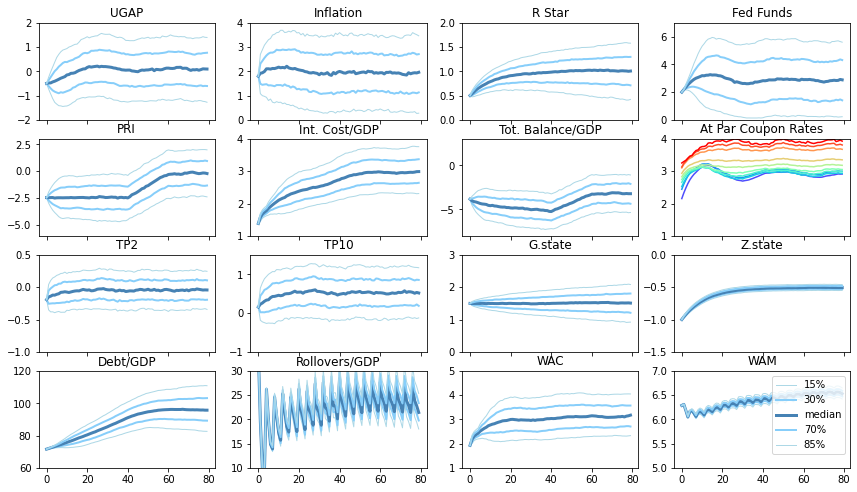

In [107]:
PlotSims2(A_SimObs, A_SimSta, A_NomsRates, DebtStorages['A_IRCost'], DebtStorages['A_DbtSvc'], DebtStorages['A_TotDfc'], DebtStorages['TotDebt'], DebtStorages['WAM'], A_NGDP)

## VII)  Strategies Performance Evaluation
The code is organized as follows:  
$\hspace{0.3 cm}$  0. Tools:
* A) Performance is a function that, given a set of strategies (static or dynamic), calls the debt block on each of them, and computes performance statistics. 
* B) PlotStrats is a function that plots the results from Performance, both as cost-risk frontiers plot and tabulating the statistics. 
1. Use the tools above on Static single-security strategies
2. Use the tools above on Static kernel-mixture issuance strategies
3. Use the tools above on Dynamic issuance strategy

### 0. Tools

#### A) Function to Compute Performance Statistics

In [108]:
def Performance(
    Init_DebtProfiles, 
    RateStorages, 
    A_SimObs, 
    A_NGDP, 
    Securities, 
    Const_and_MEVs=None, 
    M_Kernels=None, 
    CoeffstoConst_and_MEVs=None, 
    SingleIssuance = False, 
    Static = False, 
    Dynamic = False, 
    QuartersperCoup=1,
    n_period = 80,
    n_exp_horizon = 201,
    n_simula = 2000):
    """
    This function takes as key input the set of Securities to be issued, and issuance strategy in terms of Kernels and Coefficients of Kernels to MEVs and constant.
    If Static = True, Kernel x Coeff x Constant gives the strategy as issuance shares.
    If Dynamic = True, the Kernel x Coeff x MeVs is pre-computed for all MEVs except interest cost MEV. The component generated by Interest Cost MEV will be added inside the debt block. This will give a dollar amount to be issued at all securities and tenors (to be adjusted by h_index).
    If SingleIssuance = True, the strategies simply set to are include all strategies that set issuance shate to 1 for one of the given securities.
    Then for each strategy, the strategy, interest rates arrays, storage arrays for debt objects, and initial debt profiles are passed to the debt block function
    Finally, performance statistics are computed: average interest cost, std dev of interest cost, std dev of total deficit, and correlation between primary deficit and interest cost. Notice that statistics are computed across simulations, for the final period (or averaged across some periods)
    """
    
    assert (SingleIssuance  + Static  + Dynamic == 1), "Set to True one and only one option: SingleIssuance, Stati, Dynamic"  
    n_securi = Securities.shape[1]
    if SingleIssuance == True: N_strats = n_securi; CoeffstoConst_and_MEVs_i = None
    else: N_strats = CoeffstoConst_and_MEVs.shape[2]
    Avg_IssRate = xp.zeros(N_strats, dtype= xp.float32)
    Avg_IRCost = xp.zeros(N_strats, dtype= xp.float32)
    Std_IRCost = xp.zeros(N_strats, dtype= xp.float32)
    Std_TotBal = xp.zeros(N_strats, dtype= xp.float32)
    Cor_IRC_PRI = xp.zeros(N_strats, dtype= xp.float32)
    DebtStorages = F_MakeDebtStorages(n_period,n_exp_horizon,n_simula)
    IssuanceStrat = xp.zeros((n_period, n_securi, n_simula), dtype = xp.float32)
    UnadjustedKernelIssuance, SumUnadjustedKernelIssuance = None, None
    for i in trange(N_strats):
        if SingleIssuance == True:
            IssuanceStrat*=0; IssuanceStrat[:,i,:]=1
        elif Static == True:
            CoeffstoConst_and_MEVs_i = CoeffstoConst_and_MEVs[:,:,i]
            IssuanceStrat[:,:,:] = xp.tile( xp.expand_dims(M_Kernels @ CoeffstoConst_and_MEVs_i, axis=0),  (n_period, 1, n_simula)   )
        elif Dynamic == True: #Dynamic: Kernels coefficients give dollars of issuance, not shares.  IssuanceStrat will be overwritten
            CoeffstoConst_and_MEVs_i = CoeffstoConst_and_MEVs[:,:,i]
            UnadjustedKernelIssuance =   M_Kernels[:,1:]    @  (CoeffstoConst_and_MEVs_i @ Const_and_MEVs) # Dollar Issuance caused by Kernelse else than Baseline   
            SumUnadjustedKernelIssuance = xp.sum(UnadjustedKernelIssuance, axis = 1) 
            #F_Kernels2Strategy(IssuanceStrat, Const_and_MEVs, M_Kernels, CoeffstoConst_and_MEVs[:,:,i], static = static)
        #MakeDbtPaths1(Init_DbtFVout, Init_AvgCoupRate, Init_TipsFVadj, Init_FrnsFV, IssuanceStrat, NomsPos,  TipsPos,  FrnsPos, NomsTenors, TipsTenors, FrnsTenors, MaxFrnsTen, A_NomsRates_view, A_TipsRates_view, A_FrnsRates_view, A_SimObs, A_NGDP, *list(DebtStorages.values()), M_Kernels, UnadjustedKernelIssuance, SumUnadjustedKernelIssuance,TrackWAM=False, Dynamic = Dynamic, QuartersperCoup=QuartersperCoup )
        MakeDbtPaths1(*Init_DebtProfiles, IssuanceStrat, *RateStorages, A_SimObs, A_NGDP, *list(DebtStorages.values()), M_Kernels, CoeffstoConst_and_MEVs_i, UnadjustedKernelIssuance, SumUnadjustedKernelIssuance,TrackWAM=False, Dynamic = Dynamic, QuartersperCoup=QuartersperCoup, verbose = False)
        DebtStorages['A_IRCost'] /= A_NGDP
        DebtStorages['A_IRCost'] *= 400
        Axis = 1 #Select 1 to compute statistics across simulations for a fixed period, then average across periods. Select 0 to do the converse: compute stats across periods for a fixed simulation, then average across simulations. 
        Startperiod =79 #Starting period for statistics window. Select a number from 1 to 79 (or -1)    
        Avg_IssRate[i] = xp.mean(DebtStorages['Avg_IssRate'][Startperiod:])
        Avg_IRCost[i] = xp.mean(xp.mean(DebtStorages['A_IRCost'][Startperiod:,:], axis= Axis ))
        Std_IRCost[i] = xp.mean(xp.std( DebtStorages['A_IRCost'][Startperiod:,:], axis= Axis )) #xp.mean(xp.std( A_IRCost[1:,:], axis=0 ))
        Std_TotBal[i] = xp.mean(xp.std(-A_SimObs[Startperiod:,6,:] + DebtStorages['A_IRCost'][Startperiod:,:], axis=Axis )) #xp.mean(xp.std(-A_SimObs[1:,6,:] + A_IRCost[1:,:], axis=0 ))
        Cor_IRC_PRI[i] = xp.mean(  xp.mean((DebtStorages['A_IRCost'][Startperiod:,:] - xp.mean(DebtStorages['A_IRCost'][Startperiod:,:], axis=Axis, keepdims=True))*(-A_SimObs[Startperiod:,6,:] - xp.mean(-A_SimObs[Startperiod:,6,:], axis=Axis, keepdims=True)), axis=Axis)/(xp.std(DebtStorages['A_IRCost'][Startperiod:,:], axis=Axis)*xp.std(-A_SimObs[Startperiod:,6,:], axis=Axis))  )
    return Avg_IssRate, Avg_IRCost, Std_IRCost, Std_TotBal, Cor_IRC_PRI

#### B) Function to plot Performance Statistics

In [109]:
def PlotStrats(
    Avg_IssRate, 
    Avg_IRCost,
    Std_IRCost,
    Std_TotBal, 
    Cor_IRC_PRI, 
    Title, 
    StratNames=[], 
    ColorList=None, 
    M_style='o', 
    Y_lim=(None,None) , 
    X_lim=(None,None), 
    XX_lim=(None,None), 
    Tabulate=True ):
    """
    Plots the performance frontiers of strategies in the interest cost - risk space, where risk is std (interest cost) for the right panel and std(total deficit) for the right panel
    Also, tabulates the performance statistics and average issuance rates. 
    """
    
    if xp!= np: X=Std_IRCost.get(); Y=Avg_IRCost.get(); XX=Std_TotBal.get(); XXX=Cor_IRC_PRI.get(); Z=Avg_IssRate.get()
    else : X=Std_IRCost; Y=Avg_IRCost; XX=Std_TotBal; XXX=Cor_IRC_PRI; Z=Avg_IssRate
    fig4, axes = plt.subplots(nrows= 1, ncols= 2 , sharex='none', sharey=True, figsize=(16,4))
    axes[0].scatter(X,Y, c=ColorList, marker=M_style); axes[0].set_xlabel("Std IR Cost"); axes[0].set_ylabel("Avg IR Cost"); axes[0].set_title(Title + " AvG int cost vs StD int cost",fontsize=9);axes[0].set_ylim(Y_lim); axes[0].set_xlim(X_lim)
    axes[1].scatter(XX,Y,c=ColorList, marker=M_style);axes[1].set_xlabel("Std Deficit"); axes[1].set_ylabel("Avg IR Cost"); axes[1].set_title(Title + " AvG int cost vs StD (int cost + pri. deficit)",fontsize=9); axes[1].set_xlim(XX_lim) 
    for i, label in enumerate(StratNames): 
        axes[0].annotate(label, (X[i], Y[i]))
        axes[1].annotate(label, (XX[i], Y[i]))
    if Tabulate==True:
        row_names = ["Average Issuance Rate", "Average IR Cost/GDP  ","StDev IR Cost/GDP  ","StDev (IR Cost/GDP + PRI Deficit/GDP)  ", "Corr (IRCost/GDP , PRI Deficit/GDP)"]
        import pandas as pd
        return pd.DataFrame([np.round(Z,2), np.round(Y,2),np.round(X,2),np.round(XX,2), np.round(XXX,2)],  row_names, [name[0:5]  for name in StratNames])

### 1. Static single-security issuance strategies
Replicate Figure 5: Performance of single security issuance strategies (and baseline) 

#### A) Compute performance of single-security issuance strategies

In [110]:
Avg_IssRate, Avg_IRCost, Std_IRCost, Std_TotBal, Cor_IRC_PRI =  Performance(
    Init_DebtProfiles, 
    RateStorages, 
    A_SimObs, 
    A_NGDP, 
    Securities = D_Setup["Securities"], 
    SingleIssuance = True, 
    QuartersperCoup=D_Setup["QuartersperCoup"],
    n_period=D_Setup["n_period"],
    n_exp_horizon=D_Setup["n_exp_horizon"],
    n_simula=D_Setup["n_simula"],
)

#### B) Figure: Single-Security Issuance Strategies

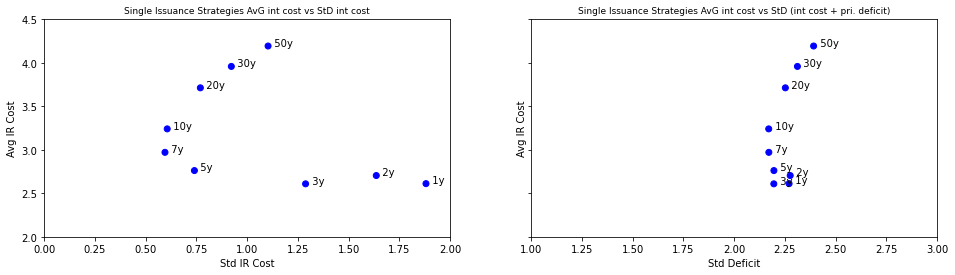

In [111]:
StratNames = [ ['  ','T ', 'F '][int(s)] + str(t) + 'y' for s,t in zip(D_Setup["Securities"][0,:], D_Setup["Securities"][1,:] ) ]
ColorList =  [ ['blue','red', 'gray'][int(s)]  for s in  D_Setup["Securities"][0,:] ]
TipsandFRN = max(D_Setup["Securities"][0,:]) > 0
table1 = PlotStrats(
    Avg_IssRate, Avg_IRCost,Std_IRCost,Std_TotBal, 
    Cor_IRC_PRI, 'Single Issuance Strategies', 
    StratNames=StratNames, 
    Y_lim=(2,4.5) , X_lim=(0+0.5*TipsandFRN,2+0.5*TipsandFRN), 
    XX_lim=(1+0.8*TipsandFRN,3-0.2*TipsandFRN), ColorList=ColorList)

#### C) Table: Single Security Issuance Strategies

In [112]:
table1

,1y,2y,3y,5y,7y,10y,20y,30y,50y
Average Issuance Rate,2.91,3.00,2.93,3.06,3.19,3.36,3.68,3.82,3.94
Average IR Cost/GDP,2.61,2.70,2.61,2.76,2.97,3.24,3.71,3.96,4.19
StDev IR Cost/GDP,1.88,1.64,1.29,0.74,0.60,0.61,0.77,0.92,1.10
StDev (IR Cost/GDP + PRI Deficit/GDP),2.27,2.28,2.20,2.20,2.17,2.17,2.25,2.31,2.39
"Corr (IRCost/GDP , PRI Deficit/GDP)",-0.35,-0.27,-0.22,-0.02,0.01,0.00,0.04,0.04,0.04


### 2. Static kernel-mixture issuance strategies
Replicate Figure 6: Performance of static mixture of kernels strategies

#### A) Compute performance of static kernel-mixture issuance strategies

In [113]:
# Prepare strategies as mixture of Kernels. 
N_StratVary = 20 # This controls how fine the mixing of kernels is. 
M_Kernels = xp.concatenate(
    (D_Setup["Kernel1_Baseline"] ,D_Setup["Kernel2_Bills"], D_Setup["Kernel3_Belly"], D_Setup["Kernel4_Bonds"]),
    axis=1)
Const = xp.ones((D_Setup["n_period"],1, D_Setup["n_simula"]),dtype=xp.float32)
CoeffstoConst = xp.zeros((M_Kernels.shape[1],1,N_StratVary*3+1), dtype=xp.float32); # Loading on each Kernel (or rows) for the value of Const and MeVs (on columns)
weight_K1 = 1
for s in range(N_StratVary*3+1):
    weight_K2 = (s>= 0*N_StratVary)*(s<1*N_StratVary)*(-0.4  +((s-0*N_StratVary)/(N_StratVary-1))*(0.5  - (-0.4 )))
    weight_K3 = (s>= 1*N_StratVary)*(s<2*N_StratVary)*(-0.08 +((s-1*N_StratVary)/(N_StratVary-1))*(0.1  - (-0.08)))
    weight_K4 = (s>= 2*N_StratVary)*(s<3*N_StratVary)*(-0.0  +((s-2*N_StratVary)/(N_StratVary-1))*(0.25 - (-0.0 )))
    CoeffstoConst[:,0,s] = xp.array([weight_K1, weight_K2,weight_K3 , weight_K4], dtype=xp.float32)             # Set Coefficients to Constant Only.

# Compute performance of strategies
Avg_IssRate, Avg_IRCost, Std_IRCost, Std_TotBal, Cor_IRC_PRI =  Performance(
    Init_DebtProfiles, 
    RateStorages, 
    A_SimObs, 
    A_NGDP, 
    Securities = D_Setup["Securities"], 
    Const_and_MEVs=Const,  
    M_Kernels=M_Kernels, 
    CoeffstoConst_and_MEVs=CoeffstoConst, 
    Static=True, 
    QuartersperCoup=D_Setup["QuartersperCoup"],
    n_period=D_Setup["n_period"],
    n_exp_horizon=D_Setup["n_exp_horizon"],
    n_simula=D_Setup["n_simula"],
)

#### B) Figure: plot performance of static kernel-mixture issuance strategies

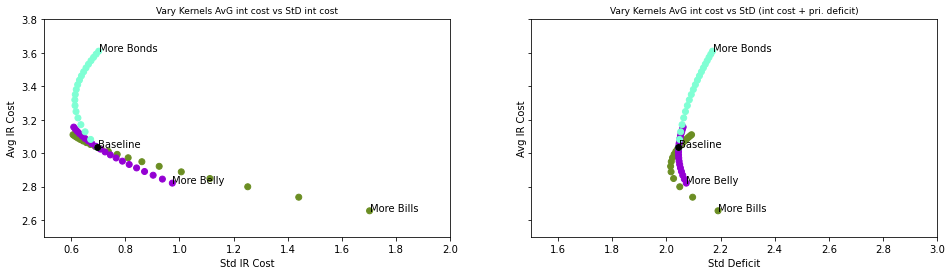

In [114]:
ColorList = ['olivedrab' for x in range(N_StratVary)] + ['darkviolet' for x in range(N_StratVary)] + ['aquamarine' for x in range(N_StratVary)] + ['black']
StratNames = ['' for x in range(3*N_StratVary)] + ['Baseline']
StratNames[N_StratVary-1] = 'More Bills'; 
StratNames[2*N_StratVary-1] = 'More Belly'; 
StratNames[3*N_StratVary-1] = 'More Bonds'
PlotStrats(Avg_IssRate, Avg_IRCost,Std_IRCost,Std_TotBal, Cor_IRC_PRI, 'Vary Kernels', ColorList=ColorList, StratNames=StratNames, Y_lim=(2.5,3.8) , X_lim=(0.5,2), XX_lim=(1.5,3), Tabulate=False)

### 3. Dynamic issuance strategy
Replicate Fig 13 and Fig 11 of Belton et al with Dynamic Strategy having Coefficients as in Fig 10

#### A) If ReplicateBelton ==  True, need to re-compute macro block and rates block
This is because Fig 11 and Fig 13 in Belton et al were done with different starting states than the ones for Fig 4.

In [115]:
if D_Setup["ReplicateBelton"] ==  True:   
    del A_SimSta, A_SimObs, A_NomsRates, A_TipsRates, A_FrnsRates, RateStorages, DebtStorages #Free up as much space as possible
    V_StaSrt = np.array([-0.5,1.5,-1.5,1.75,1.15,-0.5,1.5,-1.5,1.75,1.15,0,0,-0.55,0])
    A_SimSta = F_SimSta(D_Setup["n_period"], D_Setup["n_simula"], V_StaSrt, ModelMats) 
    A_SimObs = F_SimObs(A_SimSta, ModelMats,D_Setup["CBO_projection"],D_Setup["CBO_weight"])
    A_NomsRates, A_TipsRates, A_FrnsRates = F_SimRat(A_SimSta, A_SimObs, ModelMats, plot_rates=False, plot_coeff = False, plot_conv = False, use10y5yslope=D_Setup["use10y5yslope"], use_convadj=D_Setup["use_convadj"], plot_IRPcoeff=False, plot_IRP = False, estimate_not_assume=D_Setup["estimate_not_assume"], TP_is_for_ZeroCurve = True, replicateBeltonTP=True)
    RateStorages = F_MakeRateStorages(D_Setup["Securities"], A_NomsRates, A_TipsRates, A_FrnsRates)
    DebtStorages = F_MakeDebtStorages(D_Setup["n_period"],D_Setup["n_exp_horizon"],D_Setup["n_simula"]) 

MakeFFPaths3



MakeTPPaths2



Make IRP


#### B) Prepare dynamic strategy defined by MEVs and Coefficients of Kernels to MEVs. 
Coefficients are as in Belton et al Fig 10

In [116]:
# MEVS are: 
Const_and_MEVs  = xp.concatenate((
                                 xp.ones((D_Setup["n_period"],1, D_Setup["n_simula"]),dtype=xp.float32), # Constant, 
                                 (A_NomsRates[:,[2*4],:] - A_SimSta[:,[3],:]),                           # 2y Real Rates, 
                                 A_SimObs[:,[4],:],                                                      # 10y Term Premium
                                 - xp.expand_dims(A_SimObs[:,6,:] * A_NGDP /400, axis=1) ),              # Deficit (Only PRI here, IRCost will be added in Debt Loop).
                                 axis=1 )  
# Coefficients are:
CoeffstoConst_and_MEVs =  xp.array([[-279.4 , 255.2, 418.1, -0.6],  # (Non normalized) betas of K2 to Constant and MEVs
                                    [   70.6,  -6.2,  70.3,  0.3],  # (Non normalized) betas of K3 to Constant and MEVs
                                    [  -42.3,  25.0,  -5.9, -0.1]]) # (Non normalized) betas of K4 to Constant and MEVs

#### C) Replicate Fig 11: issuance shares under dynamic strategy

In [117]:
UnadjustedKernelIssuance =   M_Kernels[:,1:]    @  (CoeffstoConst_and_MEVs @ Const_and_MEVs)
SumUnadjustedKernelIssuance = xp.sum(UnadjustedKernelIssuance, axis = 1) # Very small quantities, between -0.0000009 and + 0.0000008.
n_securi = D_Setup["Securities"].shape[1]
IssuanceStrat = xp.zeros((D_Setup["n_period"], n_securi, D_Setup["n_simula"]), dtype = xp.float32)
MakeDbtPaths1(*Init_DebtProfiles, IssuanceStrat, *RateStorages, A_SimObs, A_NGDP, *list(DebtStorages.values()), M_Kernels, CoeffstoConst_and_MEVs, UnadjustedKernelIssuance, SumUnadjustedKernelIssuance,TrackWAM=True, Dynamic = True, QuartersperCoup=D_Setup["QuartersperCoup"])
if xp != np: X = IssuanceStrat[0,:,0].get(); XX = xp.mean(IssuanceStrat[79,:,:], axis=1).get()
else:        X = IssuanceStrat[0,:,0];       XX = xp.mean(IssuanceStrat[79,:,:], axis=1)
row_names = ["Dynamic Issuance Strategy at Initial MEVs", "Mean Dynamic Issuance Strategy at long-run MEVs"]
SecNames  = [ ['  ','T ', 'F '][int(s)] + str(t) + 'y' for s,t in zip(D_Setup["Securities"][0,:], D_Setup["Securities"][1,:] ) ]
print(' ')
table2 = pd.DataFrame([np.round(X,2), np.round(XX,2)],  row_names, [name[0:4]  for name in SecNames])
table2

,1y,2y,3y,5y,7y,10,20,30,50
Dynamic Issuance Strategy at Initial MEVs,0.22,0.19,0.20,0.21,0.09,0.07,0.0,0.02,0.0
Mean Dynamic Issuance Strategy at long-run MEVs,0.47,0.14,0.18,0.17,0.03,0.01,0.0,-0.00,0.0


#### D) Replicate Fig 13: performance of dynamic strategy

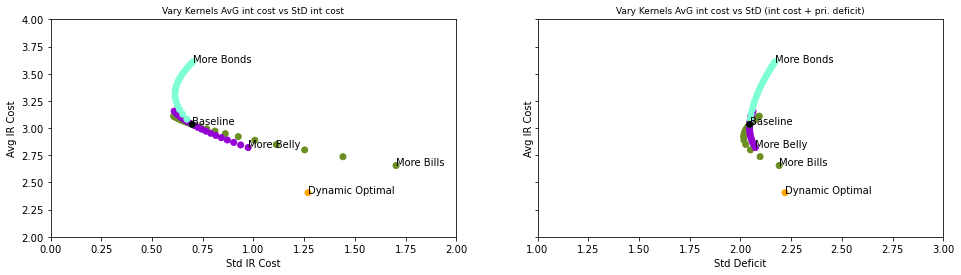

In [118]:
# Compute Strategy performance
Avg_IssRateD, Avg_IRCostD, Std_IRCostD, Std_TotBalD, Cor_IRC_PRID =  Performance(
    Init_DebtProfiles, 
    RateStorages, 
    A_SimObs, 
    A_NGDP, 
    D_Setup["Securities"], 
    Const_and_MEVs=Const_and_MEVs,  
    M_Kernels=M_Kernels, 
    CoeffstoConst_and_MEVs=xp.expand_dims(CoeffstoConst_and_MEVs, axis=2), 
    Dynamic=True, 
    QuartersperCoup=D_Setup["QuartersperCoup"],
    n_period=D_Setup["n_period"],
    n_exp_horizon=D_Setup["n_exp_horizon"],
    n_simula=D_Setup["n_simula"],
)

#Plot Performance
ColorList = ['olivedrab' for x in range(N_StratVary)] + ['darkviolet' for x in range(N_StratVary)] + ['aquamarine' for x in range(N_StratVary)] + ['black'] +['orange']
StratNames = ['' for x in range(3*N_StratVary)] + ['Baseline'] + ['Dynamic Optimal']
StratNames[N_StratVary-1] = 'More Bills'; StratNames[2*N_StratVary-1] = 'More Belly'; StratNames[3*N_StratVary-1] = 'More Bonds'
PlotStrats(xp.append(Avg_IssRate,Avg_IssRateD) , xp.append(Avg_IRCost, Avg_IRCostD) , xp.append(Std_IRCost, Std_IRCostD) , xp.append(Std_TotBal, Std_TotBalD), xp.append(Cor_IRC_PRI,Cor_IRC_PRID), 'Vary Kernels', ColorList=ColorList, StratNames=StratNames, Y_lim=(2,4) , X_lim=(0,2), XX_lim=(1,3), Tabulate=False)

In [119]:
print("Elapsed time: ", round(time()-tic,2), " secs")

Elapsed time:  38.33  secs
